# Part 1
---

## 1. Build a grid-world environment [many agents - many goals]

### Build a generalizable n-agent grid-world environment.

In [1]:
import numpy as np
import gym
from gym import spaces
from copy import copy
import matplotlib.pyplot as plt

In [2]:
class MAGridWorld(gym.Env):
    """
    Number of agents: 2-6
    Number of goals: 2-6
    Discrete action space
    Min number of state: 9
    Min number of possible rewards: 4
    Agents cannot collide
    """
    
    metadata = { 'render.modes' : ['human', 'rgb_array'] }
    
    def __init__(self, size, num_agents, max_timestep = None):
        self.size = size
        # in case the horizontal and vertical lengths change..
        self._grid_size = (self.size, self.size)
        self.world = np.zeros((self._grid_size))
        self._timestep = None
        if max_timestep == None:
            self._max_timestep = int(self.size * 4)
        else:
            self._max_timestep = max_timestep
        self.num_agents = num_agents
        # the interval between initial positions of players
        self.interval = int((self.size - 1)/(num_agents - 1))
        self._step_cost = -0.1
        self.observation_space = spaces.Box(low = 0,
                                            high = self.size,
                                            shape = (self.size, self.size))
        # 5 types of actions: up, down, left, right, halt
        self.action_space = spaces.Discrete(5)
        
    def reset(self):
        self.agent_pos = []
        self.goal_pos = []
        self._timestep = 0
        self.done = [False for i in range(self.num_agents)]
        for i in range(self.num_agents):
            self.agent_pos.append([self.size - 1, i * self.interval])
            self.goal_pos.append([0, i * self.interval])
        self.goal_pos.reverse()
        observation = self.agent_pos
        
        return observation

    # to measure the distance between an agent's position and the goal
    def _compute_distance(self, x, y):
        dist = np.abs(x[0] - y[0]) + np.abs(x[1] - y[1])
        
        return dist
    
    def _is_inside_grid(self, pos):
        return (0 <= pos[0] < self._grid_size[0]) and (0 <= pos[1] < self._grid_size[1])

    def _is_collision(self, new_pos, agent):
        for i in range(self.num_agents):
            if i == agent:
                continue
            elif new_pos == self.agent_pos[i]:
                return True
            # Each agent is not supposed to reach others' goals.
            elif new_pos == self.goal_pos[i]:
                return True
        
    def step(self, actions):
        # Instantiate dones.
        self._timestep += 1
        old_pos = self.agent_pos.copy()
        # Instantiate rewards.
        rewards = [0 for _ in range(self.num_agents)]
               
        # the next states and the rewards for each player
        for i in range(self.num_agents):
            self.update_agent_pos(i, actions[i])
            old_dist = self._compute_distance(old_pos[i],
                                              self.goal_pos[i])
            new_dist = self._compute_distance(self.agent_pos[i],
                                              self.goal_pos[i])
            
            # the rewards
            if new_dist == 0:
                self.done[i] = True
                rewards[i] = 1
            else:
                if old_dist > new_dist:
                    rewards[i] = 0.1
                else:
                    rewards[i] = -0.2
                
        if self._timestep >= self._max_timestep:
            self.done = [True for i in range(self.num_agents)]                                
                            
        for i in range(self.num_agents):
            for j in range(self.num_agents):
                if self.agent_pos[i][0] >= self.size * 0.5 and self.agent_pos[j][0] >= self.size * 0.5:
                    if self._compute_distance(self.agent_pos[i], self.agent_pos[j]) <= 1:
                        rewards[i] -= 0.5
                        rewards[j] -= 0.5
        
        observation = self.agent_pos
        info = {}
        
        return observation, rewards, self.done, info

    def update_agent_pos(self, agent, action):
        next_pos = copy(self.agent_pos[agent])
        if action == 0: # down
            next_pos[0] += 1
        elif action == 1: # up
            next_pos[0] -= 1
        elif action == 2: # right
            next_pos[1] += 1
        elif action == 3: # left
            next_pos[1] -= 1
        elif action == 4: # halt
            pass
        else:
            raise Exception('The action is not valid.')
        
        # for safety of the environment
        next_pos[0] = np.clip(next_pos[0], 0, self.size - 1)
        next_pos[1] = np.clip(next_pos[1], 0, self.size - 1)
        
        if not self._is_collision(next_pos, agent):
            self.agent_pos[agent] = next_pos
        else:
            pass
                    
    def render(self):
        state = np.copy(self.world)
        for i in range(self.num_agents):
            state[tuple(self.agent_pos[i])] = 1 - (0.7 / self.num_agents * i)
            state[tuple(self.goal_pos[i])] = 1 - (0.7 / self.num_agents * i)
        
        return plt.imshow(state)

### Run random agents for at least 10 timesteps to show that the environment logic is defined correctly. Print the current state, chosen action for each agents, reward and return your grid-world visualization for each step.

In [3]:
config = {
    'NUM_AGENTS': 4,
    'GRID_SIZE': 10,
    'NUM_EPISODES': 10
}

Step: 1
Actions: [3 4 3 3]
States:  [[9, 0], [9, 3], [9, 5], [9, 8]]
Rewards: [-1.2, -1.2, -0.9, -0.9]


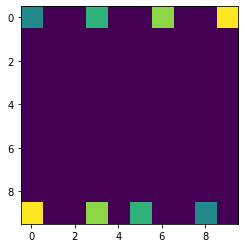

Step: 2
Actions: [1 4 0 2]
States:  [[8, 0], [9, 3], [9, 5], [9, 9]]
Rewards: [-0.9, -1.2, -1.2, -1.2]


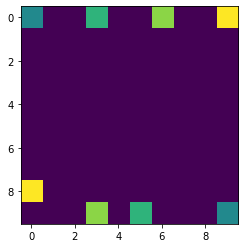

Step: 3
Actions: [3 0 4 0]
States:  [[8, 0], [9, 3], [9, 5], [9, 9]]
Rewards: [-1.2, -1.2, -1.2, -1.2]


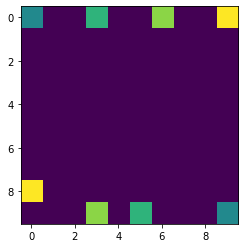

Step: 4
Actions: [3 0 0 0]
States:  [[8, 0], [9, 3], [9, 5], [9, 9]]
Rewards: [-1.2, -1.2, -1.2, -1.2]


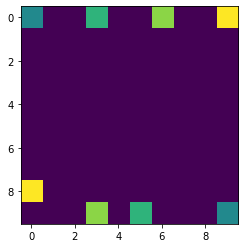

Step: 5
Actions: [4 0 2 2]
States:  [[8, 0], [9, 3], [9, 6], [9, 9]]
Rewards: [-1.2, -1.2, -1.2, -1.2]


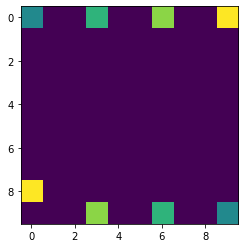

Step: 6
Actions: [0 3 1 0]
States:  [[9, 0], [9, 2], [8, 6], [9, 9]]
Rewards: [-1.2, -1.2, -0.9, -1.2]


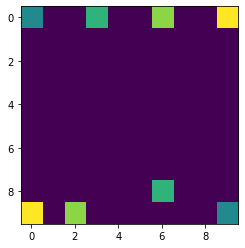

Step: 7
Actions: [4 3 2 1]
States:  [[9, 0], [9, 1], [8, 7], [8, 9]]
Rewards: [-2.2, -2.2, -1.2, -0.9]


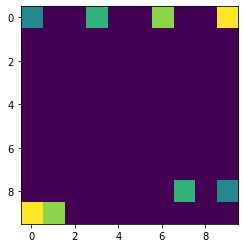

Step: 8
Actions: [2 4 4 4]
States:  [[9, 0], [9, 1], [8, 7], [8, 9]]
Rewards: [-2.2, -2.2, -1.2, -1.2]


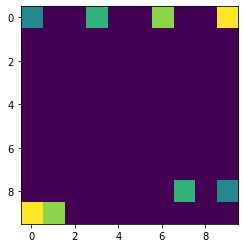

Step: 9
Actions: [2 2 2 4]
States:  [[9, 0], [9, 2], [8, 8], [8, 9]]
Rewards: [-1.2, -0.9, -2.2, -2.2]


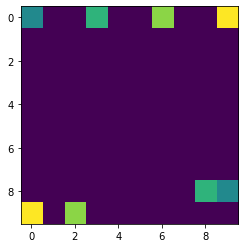

Step: 10
Actions: [1 4 2 0]
States:  [[8, 0], [9, 2], [8, 8], [9, 9]]
Rewards: [-0.9, -1.2, -1.2, -1.2]


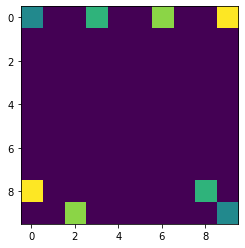

In [4]:
if __name__ == '__main__':
    num_agents = config['NUM_AGENTS']
    size = config['GRID_SIZE']
    env = MAGridWorld(size = size, num_agents = num_agents)
    env.reset()
    env.render()
    
    for s in range(config['NUM_EPISODES']):
        # Random Agents for 10 times!
        action_n = np.random.randint(5, size = config['NUM_AGENTS'])
        state, reward, done, _ = env.step(action_n)
        print(f'Step: {s + 1}')
        print(f'Actions: {action_n}')
        print(f'States:  {state}')
        print(f'Rewards: {reward}')
        env.render()
        plt.show()
        print('=' * 50)

### Describe the environment that you defined. Provide a set of actions, states, rewards, main objectives, etc.

- `Actions`: up, down, right, left, halt
    - All agents cannot get out of the defined gridworld. (AI safety)
- `States`: 100 cells (10 X 10)
    - 4 goals (a goal for each agent)
    - 4 starting points
- `Rewards`:
    - If closer to the goal, 0.1. Otherwise, -0.2.
    - If arrive at the goal, 1.0.
    - If the distance between agents is 1.0 in positions below the middle, they additionally obtain -0.5.
- `Main Objective`: Each agent must get to its own goal!

## 2. Build a grid-world environment [many agents - one goal]

### Build a generalizable n-agent grid-world environment.

In [5]:
import math

In [6]:
class MAGridWorld2(gym.Env):
    """
    Number of agents: 2-6
    Number of goals: 1-2
    Discrete action space
    Min number of state: 12
    Min number of possible rewards: 4
    Agents cannot collide
    Reward function is based on each agent’s action and the overall reward of the system
    """
    
    metadata = { 'render.modes' : ['human', 'rgb_array'] }
    
    def __init__(self, size, num_agents, goal_pos, max_timestep = None):
        self.size = size
        # in case the horizontal and vertical lengths change..
        self._grid_size = (self.size, self.size)
        self.world = np.zeros((self._grid_size))
        self._timestep = None
        if max_timestep == None:
            self._max_timestep = int(self.size * 4)
        else:
            self._max_timestep = max_timestep
        self.num_agents = num_agents
        # the interval between initial positions of players
        self.interval = int((self.size - 1)/(num_agents - 1))
        self._step_cost = -0.1
        self.observation_space = spaces.Box(low = 0,
                                            high = self.size,
                                            shape = (self.size, self.size))
        # 5 types of actions: up, down, left, right, halt
        self.action_space = spaces.Discrete(5)
        if goal_pos <= self.size:
            self.goal_pos = [0, goal_pos]
        else:
            raise Exception('Invalid goal position')
        
    def reset(self):
        self.agent_pos = []
        self._timestep = 0
        self.done = [False for i in range(self.num_agents)]
        for i in range(self.num_agents):
            self.agent_pos.append([self.size - 1, i * self.interval])
        observation = self.agent_pos
        
        return observation

    # to measure the distance between an agent's position and the goal
    def _compute_distance(self, x, y):
        dist = np.abs(x[0] - y[0]) + np.abs(x[1] - y[1])
        
        return dist
    
    def _is_inside_grid(self, pos):
        return (0 <= pos[0] < self._grid_size[0]) and (0 <= pos[1] < self._grid_size[1])

    def _is_collision(self, new_pos, agent):
        for i in range(self.num_agents):
            if i == agent:
                continue
            elif new_pos == self.agent_pos[i]:
                if new_pos == self.goal_pos:
                    return False
                else:
                    return True
        
    def step(self, actions):
        # Instantiate dones.
        self._timestep += 1
        old_pos = self.agent_pos.copy()
        # Instantiate rewards.
        rewards = [0 for _ in range(self.num_agents)]
               
        # the next states and the rewards for each player
        for i in range(self.num_agents):
            self.update_agent_pos(i, actions[i])
            old_dist = self._compute_distance(old_pos[i],
                                              self.goal_pos)
            new_dist = self._compute_distance(self.agent_pos[i],
                                              self.goal_pos)
            
            # the rewards
            if new_dist == 0:
                self.done[i] = True
                rewards[i] = 1
            else:
                if old_dist > new_dist:
                    rewards[i] = 0.1
                else:
                    rewards[i] = -0.2
        
        if self._timestep >= self._max_timestep:
            self.done = [True for i in range(self.num_agents)]    
        
        observation = self.agent_pos
        info = {}
        
        return observation, rewards, self.done, info

    def update_agent_pos(self, agent, action):
        next_pos = copy(self.agent_pos[agent])
        if action == 0: # down
            next_pos[0] += 1
        elif action == 1: # up
            next_pos[0] -= 1
        elif action == 2: # right
            next_pos[1] += 1
        elif action == 3: # left
            next_pos[1] -= 1
        elif action == 4: # halt
            pass
        else:
            raise Exception('The action is not valid.')
            
        if self._is_inside_grid(next_pos) and not self._is_collision(next_pos, agent):
            self.agent_pos[agent] = next_pos
        else:
            pass 
            
    def render(self):
        state = np.copy(self.world)
        for i in range(self.num_agents):
            state[tuple(self.agent_pos[i])] = 1 - (0.7 / self.num_agents * i)
        state[tuple(self.goal_pos)] = 0.2
        
        return plt.imshow(state)

### Run random agents for at least 10 timesteps to show that the environment logic is defined correctly. Print the current state, chosen action for each agents, reward and return your grid world visualization for each step.

Step: 1
Actions: [0 4 4 2]
States:  [[9, 0], [9, 3], [9, 6], [9, 9]]
Rewards: [-0.2, -0.2, -0.2, -0.2]


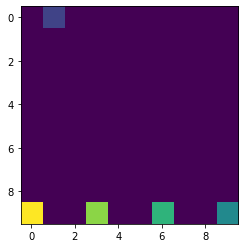

Step: 2
Actions: [4 3 1 4]
States:  [[9, 0], [9, 2], [8, 6], [9, 9]]
Rewards: [-0.2, 0.1, 0.1, -0.2]


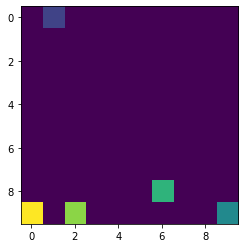

Step: 3
Actions: [4 0 2 3]
States:  [[9, 0], [9, 2], [8, 7], [9, 8]]
Rewards: [-0.2, -0.2, -0.2, 0.1]


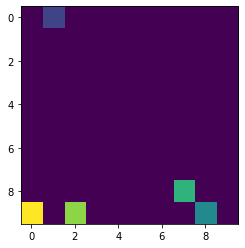

Step: 4
Actions: [2 1 0 0]
States:  [[9, 1], [8, 2], [9, 7], [9, 8]]
Rewards: [0.1, 0.1, -0.2, -0.2]


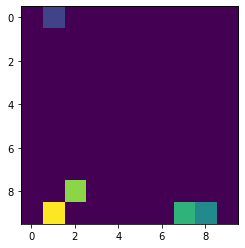

Step: 5
Actions: [4 2 4 1]
States:  [[9, 1], [8, 3], [9, 7], [8, 8]]
Rewards: [-0.2, -0.2, -0.2, 0.1]


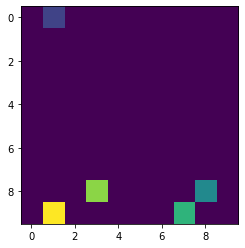

Step: 6
Actions: [4 0 4 2]
States:  [[9, 1], [9, 3], [9, 7], [8, 9]]
Rewards: [-0.2, -0.2, -0.2, -0.2]


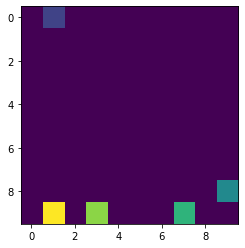

Step: 7
Actions: [0 1 0 4]
States:  [[9, 1], [8, 3], [9, 7], [8, 9]]
Rewards: [-0.2, 0.1, -0.2, -0.2]


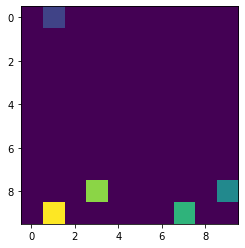

Step: 8
Actions: [0 4 4 3]
States:  [[9, 1], [8, 3], [9, 7], [8, 8]]
Rewards: [-0.2, -0.2, -0.2, 0.1]


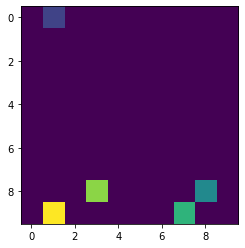

Step: 9
Actions: [4 4 1 4]
States:  [[9, 1], [8, 3], [8, 7], [8, 8]]
Rewards: [-0.2, -0.2, 0.1, -0.2]


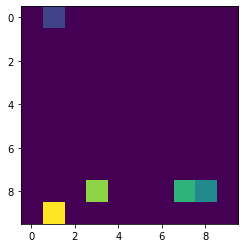

Step: 10
Actions: [2 2 4 0]
States:  [[9, 2], [8, 4], [8, 7], [9, 8]]
Rewards: [-0.2, -0.2, -0.2, -0.2]


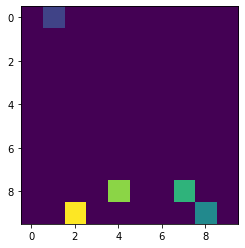

In [7]:
if __name__ == '__main__':
    num_agents = config['NUM_AGENTS']
    size = config['GRID_SIZE']
    goal_pos = np.random.choice(size)
    env_2 = MAGridWorld2(size = size, num_agents = num_agents,
                         goal_pos = goal_pos)
    env_2.reset()
    env_2.render()
    
    for s in range(config['NUM_EPISODES']):
        # Random Agents for 10 times!
        action_n = np.random.randint(5, size = config['NUM_AGENTS'])
        state, reward, done, _ = env_2.step(action_n)
        print(f'Step: {s + 1}')
        print(f'Actions: {action_n}')
        print(f'States:  {state}')
        print(f'Rewards: {reward}')
        env_2.render()
        plt.show()
        print('=' * 50)

### Describe the environment that you defined. Provide a set of actions, states, rewards, main objective, etc.

- `Actions`: up, down, right, left, halt
    - All agents cannot get out of the defined gridworld. (AI safety)
- `States`: 100 cells (10 X 10)
    - one goal (the common goal for all agents)
    - 4 starting points
- `Rewards`:
    - If closer to the goal, 0.1. Otherwise, -0.2.
    - If arrive at the goal, 1.0.
- `Main Objective`: Each agent must get to the common goal which cannot be shared!

## 3. Explore existing grid-world environments

### Step 1: Check the summary of already existing popular multi-agent environments.


https://agents.inf.ed.ac.uk/blog/multiagent-learning-environments/

### Step 2: Choose ONE environment from the list.
- Suggestion: go with an env, where
    - Observations: Discrete
    - Actions: Discretethis
    
 will help us in Part II.

I chose the `LBF` environment.

### Step 3: Run random agents for at least 10 timesteps. Print the current state, chosen action, reward and return visualization for each step.

In [8]:
# Level-Based Foraging Environments
import gym
import lbforaging.foraging
import re

for i in gym.envs.registry.all():
    if re.search('Foraging', str(i)):
        print(i)

EnvSpec(Foraging-2s-5x5-2p-1f-coop-v2)
EnvSpec(Foraging-5x5-2p-1f-coop-v2)
EnvSpec(Foraging-2s-5x5-2p-1f-v2)
EnvSpec(Foraging-5x5-2p-1f-v2)
EnvSpec(Foraging-2s-5x5-2p-2f-coop-v2)
EnvSpec(Foraging-5x5-2p-2f-coop-v2)
EnvSpec(Foraging-2s-5x5-2p-2f-v2)
EnvSpec(Foraging-5x5-2p-2f-v2)
EnvSpec(Foraging-2s-5x5-2p-3f-coop-v2)
EnvSpec(Foraging-5x5-2p-3f-coop-v2)
EnvSpec(Foraging-2s-5x5-2p-3f-v2)
EnvSpec(Foraging-5x5-2p-3f-v2)
EnvSpec(Foraging-2s-5x5-2p-4f-coop-v2)
EnvSpec(Foraging-5x5-2p-4f-coop-v2)
EnvSpec(Foraging-2s-5x5-2p-4f-v2)
EnvSpec(Foraging-5x5-2p-4f-v2)
EnvSpec(Foraging-2s-5x5-2p-5f-coop-v2)
EnvSpec(Foraging-5x5-2p-5f-coop-v2)
EnvSpec(Foraging-2s-5x5-2p-5f-v2)
EnvSpec(Foraging-5x5-2p-5f-v2)
EnvSpec(Foraging-2s-5x5-2p-6f-coop-v2)
EnvSpec(Foraging-5x5-2p-6f-coop-v2)
EnvSpec(Foraging-2s-5x5-2p-6f-v2)
EnvSpec(Foraging-5x5-2p-6f-v2)
EnvSpec(Foraging-2s-5x5-2p-7f-coop-v2)
EnvSpec(Foraging-5x5-2p-7f-coop-v2)
EnvSpec(Foraging-2s-5x5-2p-7f-v2)
EnvSpec(Foraging-5x5-2p-7f-v2)
EnvSpec(Foraging-2s-

EnvSpec(Foraging-2s-6x6-6p-1f-v2)
EnvSpec(Foraging-6x6-6p-1f-v2)
EnvSpec(Foraging-2s-6x6-6p-2f-coop-v2)
EnvSpec(Foraging-6x6-6p-2f-coop-v2)
EnvSpec(Foraging-2s-6x6-6p-2f-v2)
EnvSpec(Foraging-6x6-6p-2f-v2)
EnvSpec(Foraging-2s-6x6-6p-3f-coop-v2)
EnvSpec(Foraging-6x6-6p-3f-coop-v2)
EnvSpec(Foraging-2s-6x6-6p-3f-v2)
EnvSpec(Foraging-6x6-6p-3f-v2)
EnvSpec(Foraging-2s-6x6-6p-4f-coop-v2)
EnvSpec(Foraging-6x6-6p-4f-coop-v2)
EnvSpec(Foraging-2s-6x6-6p-4f-v2)
EnvSpec(Foraging-6x6-6p-4f-v2)
EnvSpec(Foraging-2s-6x6-6p-5f-coop-v2)
EnvSpec(Foraging-6x6-6p-5f-coop-v2)
EnvSpec(Foraging-2s-6x6-6p-5f-v2)
EnvSpec(Foraging-6x6-6p-5f-v2)
EnvSpec(Foraging-2s-6x6-6p-6f-coop-v2)
EnvSpec(Foraging-6x6-6p-6f-coop-v2)
EnvSpec(Foraging-2s-6x6-6p-6f-v2)
EnvSpec(Foraging-6x6-6p-6f-v2)
EnvSpec(Foraging-2s-6x6-6p-7f-coop-v2)
EnvSpec(Foraging-6x6-6p-7f-coop-v2)
EnvSpec(Foraging-2s-6x6-6p-7f-v2)
EnvSpec(Foraging-6x6-6p-7f-v2)
EnvSpec(Foraging-2s-6x6-6p-8f-coop-v2)
EnvSpec(Foraging-6x6-6p-8f-coop-v2)
EnvSpec(Foraging-2s-

EnvSpec(Foraging-2s-8x8-11p-2f-coop-v2)
EnvSpec(Foraging-8x8-11p-2f-coop-v2)
EnvSpec(Foraging-2s-8x8-11p-2f-v2)
EnvSpec(Foraging-8x8-11p-2f-v2)
EnvSpec(Foraging-2s-8x8-11p-3f-coop-v2)
EnvSpec(Foraging-8x8-11p-3f-coop-v2)
EnvSpec(Foraging-2s-8x8-11p-3f-v2)
EnvSpec(Foraging-8x8-11p-3f-v2)
EnvSpec(Foraging-2s-8x8-11p-4f-coop-v2)
EnvSpec(Foraging-8x8-11p-4f-coop-v2)
EnvSpec(Foraging-2s-8x8-11p-4f-v2)
EnvSpec(Foraging-8x8-11p-4f-v2)
EnvSpec(Foraging-2s-8x8-11p-5f-coop-v2)
EnvSpec(Foraging-8x8-11p-5f-coop-v2)
EnvSpec(Foraging-2s-8x8-11p-5f-v2)
EnvSpec(Foraging-8x8-11p-5f-v2)
EnvSpec(Foraging-2s-8x8-11p-6f-coop-v2)
EnvSpec(Foraging-8x8-11p-6f-coop-v2)
EnvSpec(Foraging-2s-8x8-11p-6f-v2)
EnvSpec(Foraging-8x8-11p-6f-v2)
EnvSpec(Foraging-2s-8x8-11p-7f-coop-v2)
EnvSpec(Foraging-8x8-11p-7f-coop-v2)
EnvSpec(Foraging-2s-8x8-11p-7f-v2)
EnvSpec(Foraging-8x8-11p-7f-v2)
EnvSpec(Foraging-2s-8x8-11p-8f-coop-v2)
EnvSpec(Foraging-8x8-11p-8f-coop-v2)
EnvSpec(Foraging-2s-8x8-11p-8f-v2)
EnvSpec(Foraging-8x8-11p

EnvSpec(Foraging-11x11-12p-6f-v2)
EnvSpec(Foraging-2s-11x11-12p-7f-coop-v2)
EnvSpec(Foraging-11x11-12p-7f-coop-v2)
EnvSpec(Foraging-2s-11x11-12p-7f-v2)
EnvSpec(Foraging-11x11-12p-7f-v2)
EnvSpec(Foraging-2s-11x11-12p-8f-coop-v2)
EnvSpec(Foraging-11x11-12p-8f-coop-v2)
EnvSpec(Foraging-2s-11x11-12p-8f-v2)
EnvSpec(Foraging-11x11-12p-8f-v2)
EnvSpec(Foraging-2s-11x11-12p-9f-coop-v2)
EnvSpec(Foraging-11x11-12p-9f-coop-v2)
EnvSpec(Foraging-2s-11x11-12p-9f-v2)
EnvSpec(Foraging-11x11-12p-9f-v2)
EnvSpec(Foraging-2s-11x11-13p-1f-coop-v2)
EnvSpec(Foraging-11x11-13p-1f-coop-v2)
EnvSpec(Foraging-2s-11x11-13p-1f-v2)
EnvSpec(Foraging-11x11-13p-1f-v2)
EnvSpec(Foraging-2s-11x11-13p-2f-coop-v2)
EnvSpec(Foraging-11x11-13p-2f-coop-v2)
EnvSpec(Foraging-2s-11x11-13p-2f-v2)
EnvSpec(Foraging-11x11-13p-2f-v2)
EnvSpec(Foraging-2s-11x11-13p-3f-coop-v2)
EnvSpec(Foraging-11x11-13p-3f-coop-v2)
EnvSpec(Foraging-2s-11x11-13p-3f-v2)
EnvSpec(Foraging-11x11-13p-3f-v2)
EnvSpec(Foraging-2s-11x11-13p-4f-coop-v2)
EnvSpec(Fora

EnvSpec(Foraging-12x12-8p-5f-v2)
EnvSpec(Foraging-2s-12x12-8p-6f-coop-v2)
EnvSpec(Foraging-12x12-8p-6f-coop-v2)
EnvSpec(Foraging-2s-12x12-8p-6f-v2)
EnvSpec(Foraging-12x12-8p-6f-v2)
EnvSpec(Foraging-2s-12x12-8p-7f-coop-v2)
EnvSpec(Foraging-12x12-8p-7f-coop-v2)
EnvSpec(Foraging-2s-12x12-8p-7f-v2)
EnvSpec(Foraging-12x12-8p-7f-v2)
EnvSpec(Foraging-2s-12x12-8p-8f-coop-v2)
EnvSpec(Foraging-12x12-8p-8f-coop-v2)
EnvSpec(Foraging-2s-12x12-8p-8f-v2)
EnvSpec(Foraging-12x12-8p-8f-v2)
EnvSpec(Foraging-2s-12x12-8p-9f-coop-v2)
EnvSpec(Foraging-12x12-8p-9f-coop-v2)
EnvSpec(Foraging-2s-12x12-8p-9f-v2)
EnvSpec(Foraging-12x12-8p-9f-v2)
EnvSpec(Foraging-2s-12x12-9p-1f-coop-v2)
EnvSpec(Foraging-12x12-9p-1f-coop-v2)
EnvSpec(Foraging-2s-12x12-9p-1f-v2)
EnvSpec(Foraging-12x12-9p-1f-v2)
EnvSpec(Foraging-2s-12x12-9p-2f-coop-v2)
EnvSpec(Foraging-12x12-9p-2f-coop-v2)
EnvSpec(Foraging-2s-12x12-9p-2f-v2)
EnvSpec(Foraging-12x12-9p-2f-v2)
EnvSpec(Foraging-2s-12x12-9p-3f-coop-v2)
EnvSpec(Foraging-12x12-9p-3f-coop-v2)


EnvSpec(Foraging-2s-14x14-14p-2f-v2)
EnvSpec(Foraging-14x14-14p-2f-v2)
EnvSpec(Foraging-2s-14x14-14p-3f-coop-v2)
EnvSpec(Foraging-14x14-14p-3f-coop-v2)
EnvSpec(Foraging-2s-14x14-14p-3f-v2)
EnvSpec(Foraging-14x14-14p-3f-v2)
EnvSpec(Foraging-2s-14x14-14p-4f-coop-v2)
EnvSpec(Foraging-14x14-14p-4f-coop-v2)
EnvSpec(Foraging-2s-14x14-14p-4f-v2)
EnvSpec(Foraging-14x14-14p-4f-v2)
EnvSpec(Foraging-2s-14x14-14p-5f-coop-v2)
EnvSpec(Foraging-14x14-14p-5f-coop-v2)
EnvSpec(Foraging-2s-14x14-14p-5f-v2)
EnvSpec(Foraging-14x14-14p-5f-v2)
EnvSpec(Foraging-2s-14x14-14p-6f-coop-v2)
EnvSpec(Foraging-14x14-14p-6f-coop-v2)
EnvSpec(Foraging-2s-14x14-14p-6f-v2)
EnvSpec(Foraging-14x14-14p-6f-v2)
EnvSpec(Foraging-2s-14x14-14p-7f-coop-v2)
EnvSpec(Foraging-14x14-14p-7f-coop-v2)
EnvSpec(Foraging-2s-14x14-14p-7f-v2)
EnvSpec(Foraging-14x14-14p-7f-v2)
EnvSpec(Foraging-2s-14x14-14p-8f-coop-v2)
EnvSpec(Foraging-14x14-14p-8f-coop-v2)
EnvSpec(Foraging-2s-14x14-14p-8f-v2)
EnvSpec(Foraging-14x14-14p-8f-v2)
EnvSpec(Foraging-

EnvSpec(Foraging-2s-17x17-15p-7f-v2)
EnvSpec(Foraging-17x17-15p-7f-v2)
EnvSpec(Foraging-2s-17x17-15p-8f-coop-v2)
EnvSpec(Foraging-17x17-15p-8f-coop-v2)
EnvSpec(Foraging-2s-17x17-15p-8f-v2)
EnvSpec(Foraging-17x17-15p-8f-v2)
EnvSpec(Foraging-2s-17x17-15p-9f-coop-v2)
EnvSpec(Foraging-17x17-15p-9f-coop-v2)
EnvSpec(Foraging-2s-17x17-15p-9f-v2)
EnvSpec(Foraging-17x17-15p-9f-v2)
EnvSpec(Foraging-2s-17x17-16p-1f-coop-v2)
EnvSpec(Foraging-17x17-16p-1f-coop-v2)
EnvSpec(Foraging-2s-17x17-16p-1f-v2)
EnvSpec(Foraging-17x17-16p-1f-v2)
EnvSpec(Foraging-2s-17x17-16p-2f-coop-v2)
EnvSpec(Foraging-17x17-16p-2f-coop-v2)
EnvSpec(Foraging-2s-17x17-16p-2f-v2)
EnvSpec(Foraging-17x17-16p-2f-v2)
EnvSpec(Foraging-2s-17x17-16p-3f-coop-v2)
EnvSpec(Foraging-17x17-16p-3f-coop-v2)
EnvSpec(Foraging-2s-17x17-16p-3f-v2)
EnvSpec(Foraging-17x17-16p-3f-v2)
EnvSpec(Foraging-2s-17x17-16p-4f-coop-v2)
EnvSpec(Foraging-17x17-16p-4f-coop-v2)
EnvSpec(Foraging-2s-17x17-16p-4f-v2)
EnvSpec(Foraging-17x17-16p-4f-v2)
EnvSpec(Foraging-

EnvSpec(Foraging-2s-18x18-18p-9f-v2)
EnvSpec(Foraging-18x18-18p-9f-v2)
EnvSpec(Foraging-2s-18x18-19p-1f-coop-v2)
EnvSpec(Foraging-18x18-19p-1f-coop-v2)
EnvSpec(Foraging-2s-18x18-19p-1f-v2)
EnvSpec(Foraging-18x18-19p-1f-v2)
EnvSpec(Foraging-2s-18x18-19p-2f-coop-v2)
EnvSpec(Foraging-18x18-19p-2f-coop-v2)
EnvSpec(Foraging-2s-18x18-19p-2f-v2)
EnvSpec(Foraging-18x18-19p-2f-v2)
EnvSpec(Foraging-2s-18x18-19p-3f-coop-v2)
EnvSpec(Foraging-18x18-19p-3f-coop-v2)
EnvSpec(Foraging-2s-18x18-19p-3f-v2)
EnvSpec(Foraging-18x18-19p-3f-v2)
EnvSpec(Foraging-2s-18x18-19p-4f-coop-v2)
EnvSpec(Foraging-18x18-19p-4f-coop-v2)
EnvSpec(Foraging-2s-18x18-19p-4f-v2)
EnvSpec(Foraging-18x18-19p-4f-v2)
EnvSpec(Foraging-2s-18x18-19p-5f-coop-v2)
EnvSpec(Foraging-18x18-19p-5f-coop-v2)
EnvSpec(Foraging-2s-18x18-19p-5f-v2)
EnvSpec(Foraging-18x18-19p-5f-v2)
EnvSpec(Foraging-2s-18x18-19p-6f-coop-v2)
EnvSpec(Foraging-18x18-19p-6f-coop-v2)
EnvSpec(Foraging-2s-18x18-19p-6f-v2)
EnvSpec(Foraging-18x18-19p-6f-v2)
EnvSpec(Foraging-

In [9]:
from enum import Enum
import argparse
import logging
import random
import time
import numpy as np


class Action(Enum):
    NONE = 0
    NORTH = 1
    SOUTH = 2
    WEST = 3
    EAST = 4
    LOAD = 5

logger = logging.getLogger(__name__)


def _game_loop(env, render):
    """
    """
    obs = env.reset()
    done = False

    for s in range(config['NUM_EPISODES']):

        # Random Agents for 10 times!
        actions = env.action_space.sample()
        nobs, nreward, ndone, _ = env.step(actions)
        print(f'Step: {s + 1}')
        print(f'Actions: {actions}')
        print(f'Next States: {nobs}')
        print(f'Rewards: {nreward}')
        print('=' * 50)

        if render:
            env.render()
            time.sleep(1)

        done = np.all(ndone)
    # print(env.players[0].score, env.players[1].score)


def main(game_count = 1, render = False):
    env = gym.make("Foraging-5x5-2p-1f-v2")
    obs = env.reset()

    for episode in range(game_count):
        _game_loop(env, render)


if __name__ == "__main__":
    parser = argparse.ArgumentParser(
        description = "Play the level foraging game.")

    parser.add_argument("--render", action = "store_true")
    parser.add_argument(
        "--times", type = int, default = 1,
        help = "How many times to run the game"
    )

    args, _ = parser.parse_known_args()
    main(args.times, True)

Step: 1
Actions: (5, 0)
Next States: (array([1., 3., 1., 0., 2., 1., 1., 4., 1.], dtype=float32), array([1., 3., 1., 1., 4., 1., 0., 2., 1.], dtype=float32))
Rewards: [0, 0]


c:\programdata\miniconda3\lib\site-packages\gym\spaces\box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(
c:\programdata\miniconda3\lib\site-packages\pyglet\image\codecs\wic.py:434: UserWarning: [WinError -2147417850] Cannot change thread mode after it is set
  warnings.warn(str(err))


Step: 2
Actions: (0, 4)
Next States: (array([1., 3., 1., 0., 2., 1., 1., 4., 1.], dtype=float32), array([1., 3., 1., 1., 4., 1., 0., 2., 1.], dtype=float32))
Rewards: [0, 0]
Step: 3
Actions: (3, 0)
Next States: (array([1., 3., 1., 0., 1., 1., 1., 4., 1.], dtype=float32), array([1., 3., 1., 1., 4., 1., 0., 1., 1.], dtype=float32))
Rewards: [0, 0]
Step: 4
Actions: (3, 1)
Next States: (array([1., 3., 1., 0., 0., 1., 0., 4., 1.], dtype=float32), array([1., 3., 1., 0., 4., 1., 0., 0., 1.], dtype=float32))
Rewards: [0, 0]
Step: 5
Actions: (2, 5)
Next States: (array([1., 3., 1., 1., 0., 1., 0., 4., 1.], dtype=float32), array([1., 3., 1., 0., 4., 1., 1., 0., 1.], dtype=float32))
Rewards: [0, 0]
Step: 6
Actions: (0, 1)
Next States: (array([1., 3., 1., 1., 0., 1., 0., 4., 1.], dtype=float32), array([1., 3., 1., 0., 4., 1., 1., 0., 1.], dtype=float32))
Rewards: [0, 0]
Step: 7
Actions: (4, 3)
Next States: (array([1., 3., 1., 1., 1., 1., 0., 3., 1.], dtype=float32), array([1., 3., 1., 0., 3., 1., 1

### Step 4: Describe the environment that you choose. Provide a set of actions, states, rewards, main objective, etc.

In [10]:
env_lbf = gym.make("Foraging-8x8-2p-1f-v2")
print(f"The Fruit Level Lower Bound: {env_lbf.observation_space[0].low[2]}")
print(f"The Fruit Level Upper Bound: {env_lbf.observation_space[0].high[2]}")
print(f"The Players' Level Lower Bound: {env_lbf.observation_space[0].low[5]}")
print(f"The Players' Level Lower Bound: {env_lbf.observation_space[0].high[5]}")

The Fruit Level Lower Bound: 0.0
The Fruit Level Upper Bound: 6.0
The Players' Level Lower Bound: 0.0
The Players' Level Lower Bound: 3.0


- `Actions`: None, NORTH, SOUTH, WEST, EAST, LOAD
    - All agents cannot get out of the defined gridworld. (AI safety)
    - NONE: `0`
    - NORTH: `1`
    - SOUTH: `2`
    - WEST: `3`
    - EAST: `4`
    - LOAD: `5`
- `States`: 64 cells (8 X 8)
    - FOOD (randomly scattered)
    - EMPTY
    - AGENT
    - OUT_OF_BOUND
- `Observations`:
    - (`A`, `B`, `C`, `D`, `E`, `F`, `G`, `H`, `I`)
    - the fruit's position: `A` (x-axis), `B` (y-axis)
    - the fruit level: `C` (Max Level: `6`)
    - one's own position: `D` (x-axis), `E` (y-axis)
    - one's own level: `F` (Max Level: `3`)
    - another player's position: `G` (x-axis), `H` (y-axis)
    - another player's level: `I` (Max Level: `3`)
- `Rewards`:
    - Agents are awarded points equal to the level of the food they helped collect, divided by their contribution (their level).
- `Main Objective`: Agents are supposed cooperate to gather the food as many as possible given the number of steps.

# Part 2 - Solve problems using Q-learning
---

## 1. Apply Q-learning algorithm to solve the environment that was defined in Part 1.1.

In [11]:
import time

In [12]:
class TDAgent:
    def __init__(self,
                 gamma: float,
                 num_states: int,
                 num_actions: int,
                 eps: float, # the parameter for epsilon-greedy policy
                 lr: float, # learning rate
                 num_steps: int):
        self.gamma = gamma
        self.num_states = num_states
        self.num_actions = num_actions
        self.lr = lr
        self.eps = eps
        self.num_steps = num_steps

        # Initialize state value function, 'V', and
        # action value function, 'Q'.
        self.v = None
        self.q = None
        self.reset_values()
        
        # Initialize "policy Q".
        # "policy Q" is the one used for policy generation.
        self._policy_q = None
        self.reset_policy()

    def reset_values(self):
        self.v = np.zeros(shape = self.num_states)
        self.q = np.zeros(shape = (self.num_states, self.num_actions))

    def reset_policy(self):
        self._policy_q = np.zeros(shape = (self.num_states, self.num_actions))

    def get_action(self, state, training = True):
        prob = np.random.uniform(0.0, 1.0, 1)
        # epsilon-greedy policy over Q
        if prob <= self.eps and training == True: # random policy with epsilon probability
            action = np.random.choice(range(self.num_actions))
        # greedy policy
        else:
            action = self._policy_q[state, :].argmax()
        return action

In [13]:
class QLearner(TDAgent):
    # All arguments except for the number of steps in TDAgent exist here.
    def __init__(self,
                 gamma: float,
                 num_states: int,
                 num_actions: int,
                 eps: float,
                 lr: float):
        # Inherit TDAgent.
        super(QLearner, self).__init__(gamma = gamma,
                                       num_states = num_states,
                                       num_actions = num_actions,
                                       eps = eps,
                                       lr = lr,
                                       # Set this consistent with TD(n).
                                       # In this case, TD(0).
                                       num_steps = 1)

    def get_action(self, state, training = True):
        prob = np.random.uniform(0.0, 1.0, 1)
        # e-greedy policy over Q
        if prob <= self.eps and training == True: # random policy with epsilon probability
            action = np.random.choice(range(self.num_actions))
        # greedy policy
        else:
            action = self.q[state, :].argmax()
        return action

    def update_sample(self, state, action, reward, next_state, done):
        s, a, r, ns = state, action, reward, next_state
        # Q-Learning target
        td_target = r + self.gamma * self.q[ns, :].max() * (1 - done)
        self.q[s, a] += self.lr * (td_target - self.q[s, a])

hyperparameters

In [14]:
num_episodes = 5000
gamma = 0.99 # discount rate
lr = 0.01
env = MAGridWorld(size = config['GRID_SIZE'],
                  num_agents = config['NUM_AGENTS'])
eps = 1.0 # the maximum eps: 1.0
factor = (1e-2)**(1 / num_episodes) # the minimum eps: 0.01
num_states = env.observation_space.shape[0] * env.observation_space.shape[1]
num_actions = env.action_space.n

Instantiate agents.

In [15]:
agents = []
for i in range(config['NUM_AGENTS']):
    agents.append(QLearner(gamma = gamma,
                           num_states = num_states,
                           num_actions = num_actions,
                           eps = eps,
                           lr = lr))

qlearning_rewards = []
for _ in range(config['NUM_AGENTS']):
    qlearning_rewards.append([])

training

In [16]:
start = time.time()

eps_values = []
print_every = 1000

for ep in range(num_episodes):
    states_temp = env.reset()
    states = []
    for i in range(config['NUM_AGENTS']):
        states.append(states_temp[i][0] * config['GRID_SIZE'] +\
                      states_temp[i][1])
    total_rewards = [0] * config['NUM_AGENTS']

    while True:
        actions = []
                
        for i in range(config['NUM_AGENTS']):
            # epsilon-greedy policy
            actions.append(agents[i].get_action(states[i]))
        next_states_temp, rewards, dones, _ = env.step(actions)
        next_states = []
        for i in range(config['NUM_AGENTS']):
            next_states.append(next_states_temp[i][0] * config['GRID_SIZE'] +\
                               next_states_temp[i][1])
                            
        for i in range(config['NUM_AGENTS']):
            # Q-learning: Update Q-table using greedy policy.
            agents[i].update_sample(state = states[i],
                                    action = actions[i],
                                    reward = rewards[i],
                                    next_state = next_states[i],
                                    done = dones[i])
            total_rewards[i] += rewards[i]
        
        states = next_states
        
        if sum(dones) == config['NUM_AGENTS']:
            break

    for i in range(config['NUM_AGENTS']):
        qlearning_rewards[i].append(total_rewards[i])            
            
    eps_values.append(agents[0].eps)
    
    for i in range(config['NUM_AGENTS']):
        agents[i].eps *= factor
    
    if ep % print_every == (print_every - 1):
        print(f"Episode: {ep + 1}\t| Epsilon: {agents[0].eps:.2f}")
        
end = time.time()

print(f"For {config['NUM_AGENTS']} agents," +
      f" the elapsed time: {round(end - start, 1)} seconds")

Episode: 1000	| Epsilon: 0.40
Episode: 2000	| Epsilon: 0.16
Episode: 3000	| Epsilon: 0.06
Episode: 4000	| Epsilon: 0.03
Episode: 5000	| Epsilon: 0.01
For 4 agents, the elapsed time: 33.3 seconds


Total Rewards per episode

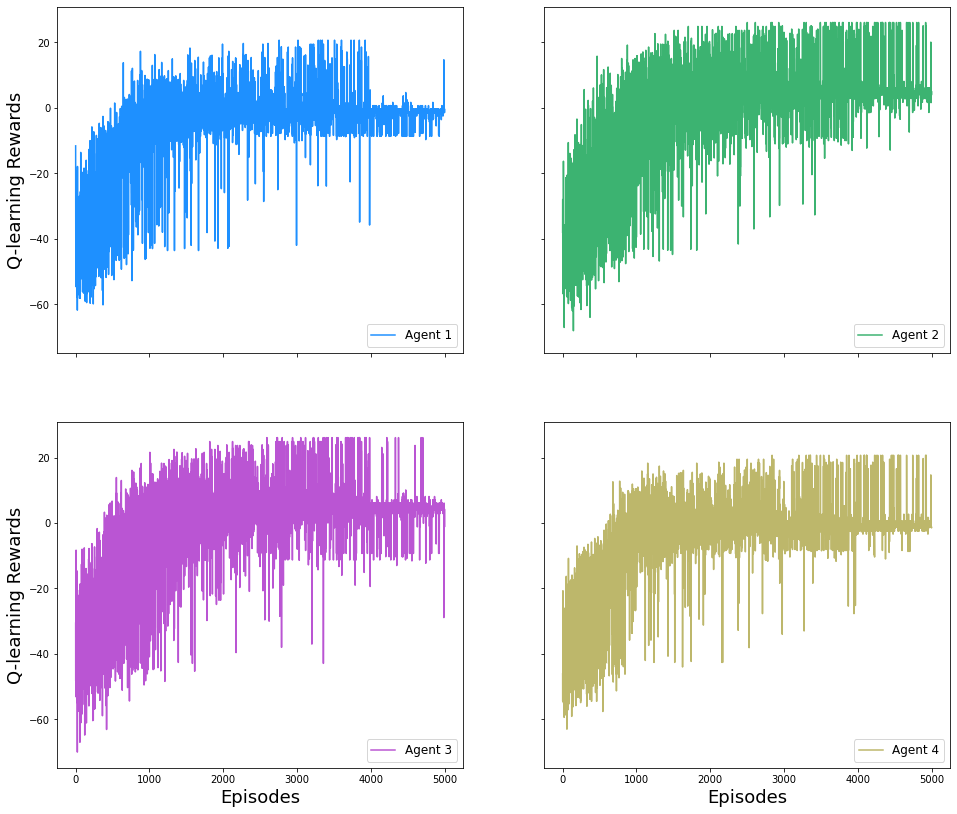

In [17]:
colors = ["dodgerblue", "mediumseagreen", "mediumorchid", "darkkhaki"]

fig, axes = plt.subplots(2, 2, sharex = True, sharey = True,
                         figsize = (16, 14))
for i in range(config['NUM_AGENTS']):
    j = i // 2
    k = i % 2
    axes[j][k].plot(qlearning_rewards[i], color = colors[i])
    if k == 0:
        axes[j][k].set_ylabel("Q-learning Rewards", color = "black",
                              fontsize = 18)
    if j == 1:
        axes[j][k].set_xlabel("Episodes", fontsize = 18)
    axes[j][k].legend(['Agent ' + str(i + 1)], fontsize = 12,
                   loc = 'lower right')
plt.show()

`Discussion on the result`<br>
The overall rewards seem to be volatile even though they converge as the number of training reaches the total episodes. So, it needs to be examined if these volatilities can be alleviated via hyperparameter tuning.

Epsilon Decay Visualization

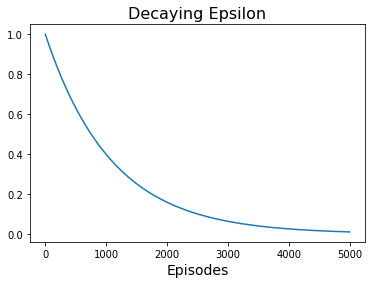

In [18]:
plt.plot(eps_values)
plt.xlabel("Episodes", fontsize = 14)
plt.title("Decaying Epsilon", fontsize = 16);

Evaluation Results

Step 1


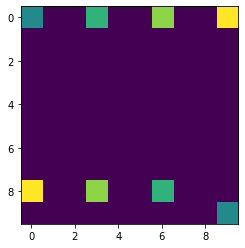

Step 2


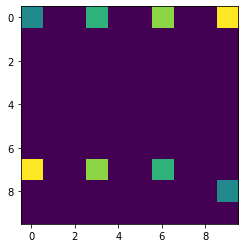

Step 3


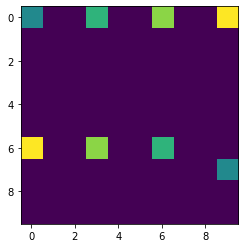

Step 4


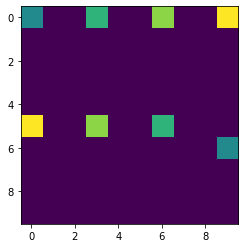

Step 5


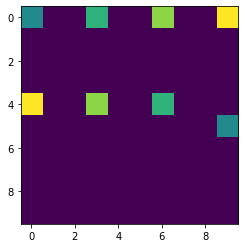

Step 6


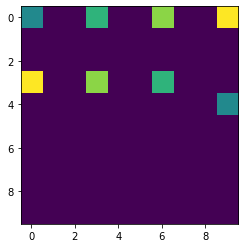

Step 7


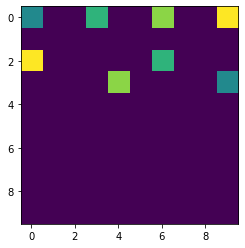

Step 8


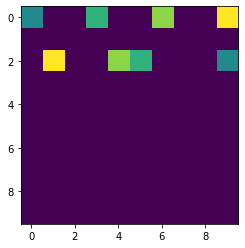

Step 9


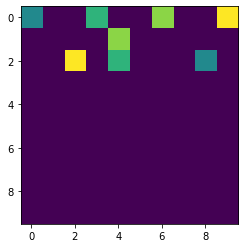

Step 10


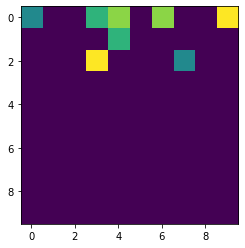

Step 11


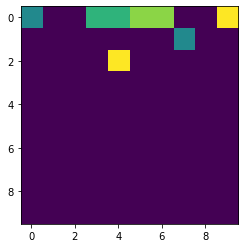

Step 12


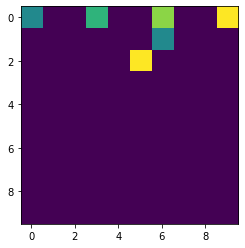

Step 13


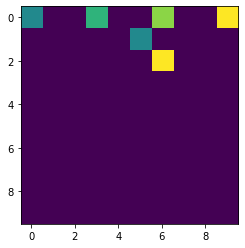

Step 14


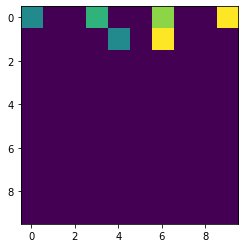

Step 15


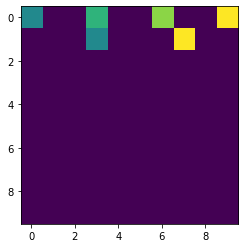

Step 16


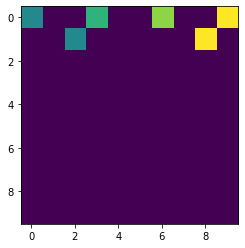

Step 17


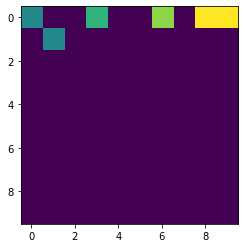

Step 18


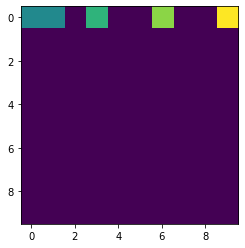

Step 19


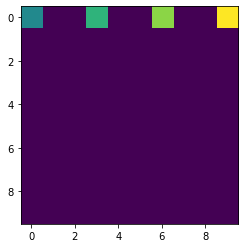

In [19]:
# Only carry out the optimal policy trained via Q-learning.
count = 0
rewards_greedy = []
states_temp = env.reset()
for i in range(config['NUM_AGENTS']):
    rewards_greedy.append([])
    states.append(states_temp[i][0] * config['GRID_SIZE'] +\
                  states_temp[i][1])
    
while True:
    actions = []
    for i in range(config['NUM_AGENTS']):
        actions.append(agents[i].get_action(states[i], training = False))
    next_states_temp, rewards, dones, _ = env.step(actions)
    next_states = []
    for i in range(config['NUM_AGENTS']):
        next_states.append(next_states_temp[i][0] * config['GRID_SIZE'] +\
                           next_states_temp[i][1])
        rewards_greedy[i].append(rewards[i])
    states = next_states
    count += 1

    print(f"Step {count}")
    env.render()
    plt.show()
    time.sleep(1)
    
    if sum(dones) == config['NUM_AGENTS']:
        break

`Discussion on the result`<br>
Except for the agent 4, all agents reach one's own goal in the optimal number of steps. The results are more or less showing decent performance. However, it needs to be examined if 
all agents can arrive at their own goals in the optimal number of steps via hyperparameter tuning.

Total Rewards per episode (evaluation results)

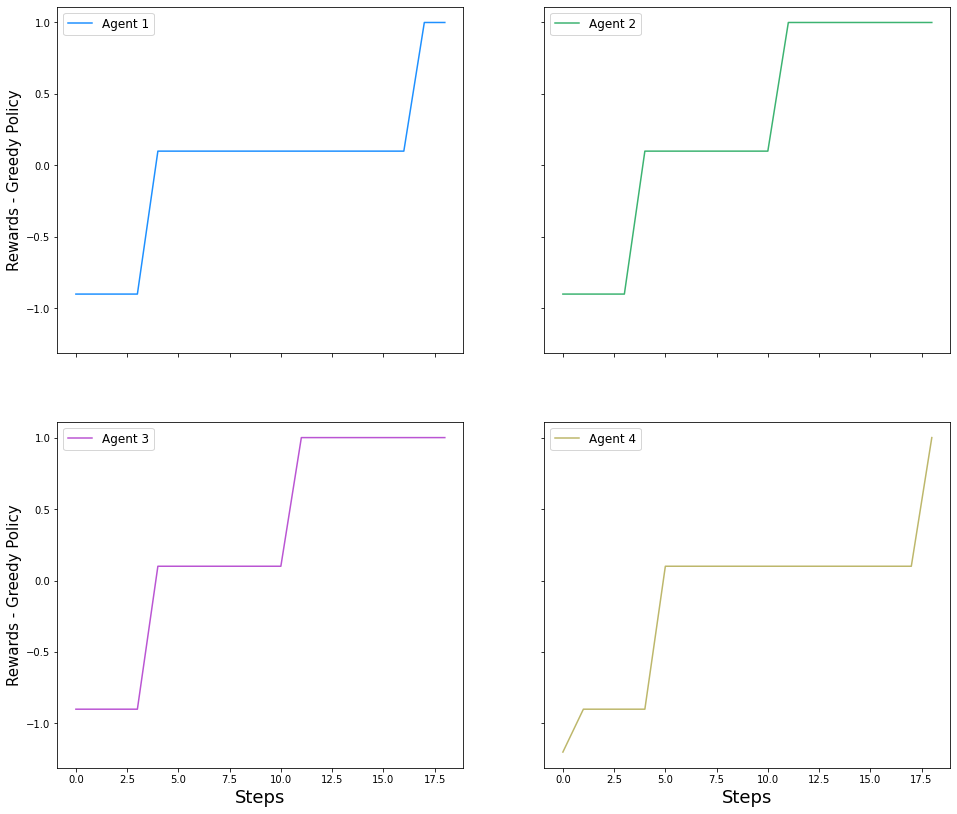

In [20]:
colors = ["dodgerblue", "mediumseagreen", "mediumorchid", "darkkhaki"]

fig, axes = plt.subplots(2, 2, sharex = True, sharey = True,
                         figsize = (16, 14))
for i in range(config['NUM_AGENTS']):
    j = i // 2
    k = i % 2
    axes[j][k].plot(rewards_greedy[i], color = colors[i])
    if k == 0:
        axes[j][k].set_ylabel("Rewards - Greedy Policy", color = "black",
                              fontsize = 15)
    if j == 1:
        axes[j][k].set_xlabel("Steps", fontsize = 18)
    axes[j][k].legend(['Agent ' + str(i + 1)], fontsize = 12)
plt.show()

## 2. Apply Q-learning algorithm to solve the environment that was defined in Part 1.2.

hyperparameters

In [21]:
num_episodes = 5000
gamma = 0.99 # discount rate
lr = 0.01
goal_pos = np.random.choice(config['GRID_SIZE'])
env_2 = MAGridWorld2(size = size, num_agents = num_agents,
                     goal_pos = goal_pos)
eps = 1.0 # the maximum eps: 1.0
factor = (1e-2)**(1 / num_episodes) # the minimum eps: 0.01
num_states = env_2.observation_space.shape[0] * env_2.observation_space.shape[1]
num_actions = env_2.action_space.n

Instantiate agents.

In [22]:
agents_2 = []
for i in range(config['NUM_AGENTS']):
    agents_2.append(QLearner(gamma = gamma,
                             num_states = num_states,
                             num_actions = num_actions,
                             eps = eps,
                             lr = lr))

qlearning_rewards_2 = []
for _ in range(config['NUM_AGENTS']):
    qlearning_rewards_2.append([])

training

In [23]:
start = time.time()
eps_values_2 = []
print_every = 1000

for ep in range(num_episodes):
    states_temp = env_2.reset()
    states = []
    ended = [0] * config['NUM_AGENTS']
    for i in range(config['NUM_AGENTS']):
        states.append(states_temp[i][0] * config['GRID_SIZE'] +\
                      states_temp[i][1])
    total_rewards = [0] * config['NUM_AGENTS']

    while True:
        actions = []
                
        for i in range(config['NUM_AGENTS']):
            # epsilon-greedy policy
            actions.append(agents_2[i].get_action(states[i]))
        for i in range(config['NUM_AGENTS']):
            if ended[i] > 0: # If the agent has already arrived at the goal..
                actions[i] = 4
        next_states_temp, rewards, dones, _ = env_2.step(actions)
        next_states = []
        for i in range(config['NUM_AGENTS']):
            next_states.append(next_states_temp[i][0] * config['GRID_SIZE'] +\
                               next_states_temp[i][1])
            if ended[i] > 0:
                rewards[i] = 0
                dones[i] = 1
                            
        for i in range(config['NUM_AGENTS']):
            # Q-learning: Update Q-table using greedy policy.
            agents_2[i].update_sample(state = states[i],
                                      action = actions[i],
                                      reward = rewards[i],
                                      next_state = next_states[i],
                                      done = dones[i])
            total_rewards[i] += rewards[i]
            if dones[i] > 0:
                ended[i] = dones[i]
        
        states = next_states
        
        if sum(dones) == config['NUM_AGENTS']:
            break

    for i in range(config['NUM_AGENTS']):
        qlearning_rewards_2[i].append(total_rewards[i])            
            
    eps_values_2.append(agents_2[0].eps)
    
    for i in range(config['NUM_AGENTS']):
        agents_2[i].eps *= factor
    
    if ep % print_every == (print_every - 1):
        print(f"Episode: {ep + 1}\t| Epsilon: {agents_2[0].eps:.2f}")
        
end = time.time()

print(f"For {config['NUM_AGENTS']} agents," +
      f" the elapsed time: {round(end - start, 1)} seconds")

Episode: 1000	| Epsilon: 0.40
Episode: 2000	| Epsilon: 0.16
Episode: 3000	| Epsilon: 0.06
Episode: 4000	| Epsilon: 0.03
Episode: 5000	| Epsilon: 0.01
For 4 agents, the elapsed time: 10.0 seconds


Total Rewards per episode

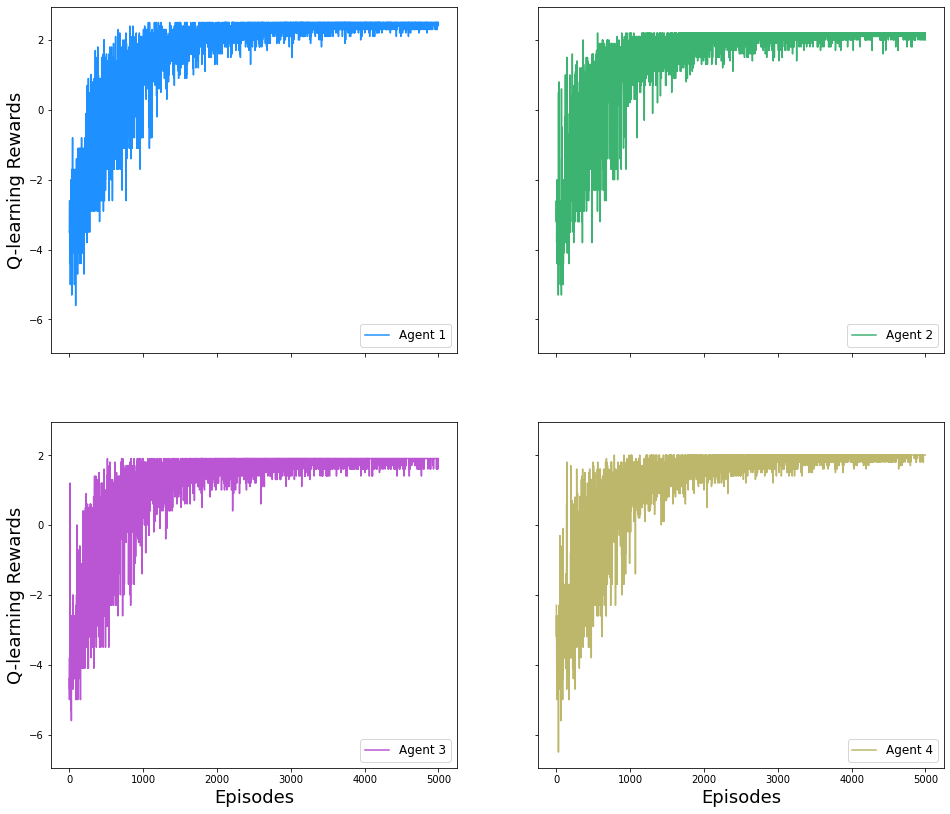

In [24]:
colors = ["dodgerblue", "mediumseagreen", "mediumorchid", "darkkhaki"]

fig, axes = plt.subplots(2, 2, sharex = True, sharey = True,
                         figsize = (16, 14))
for i in range(config['NUM_AGENTS']):
    j = i // 2
    k = i % 2
    axes[j][k].plot(qlearning_rewards_2[i], color = colors[i])
    if k == 0:
        axes[j][k].set_ylabel("Q-learning Rewards", color = "black",
                              fontsize = 18)
    if j == 1:
        axes[j][k].set_xlabel("Episodes", fontsize = 18)
    axes[j][k].legend(['Agent ' + str(i + 1)], fontsize = 12,
                   loc = 'lower right')
plt.show()

`Discussion on the result`<br>
The rewards show less volatile shape than those in the Multi-Agent GridWorld case with the same hyperparameters.

Epsilon Decay Visualization

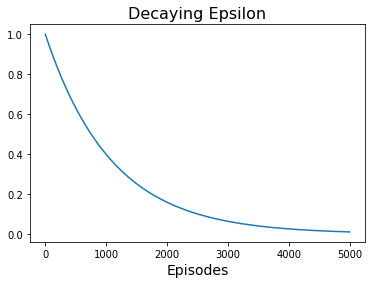

In [25]:
plt.plot(eps_values_2)
plt.xlabel("Episodes", fontsize = 14)
plt.title("Decaying Epsilon", fontsize = 16);

Evaluation Results

Step 1


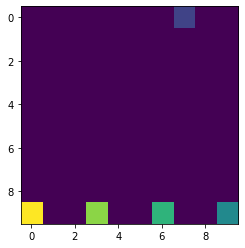

Step 2


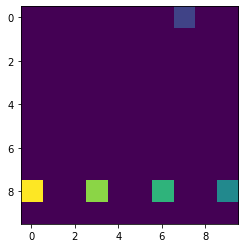

Step 3


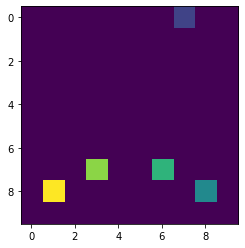

Step 4


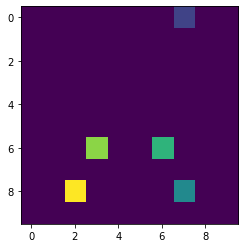

Step 5


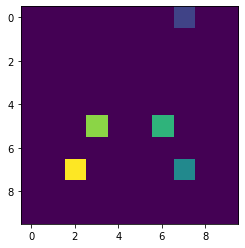

Step 6


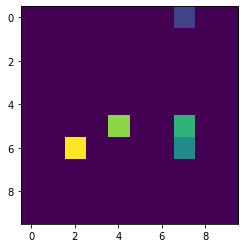

Step 7


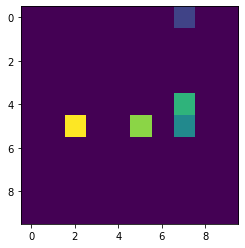

Step 8


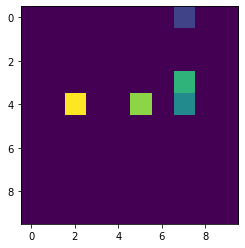

Step 9


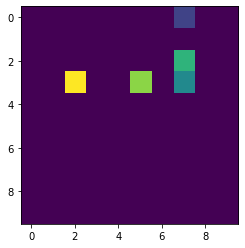

Step 10


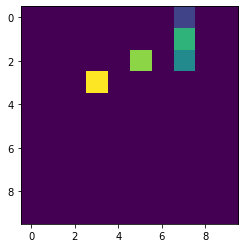

Step 11


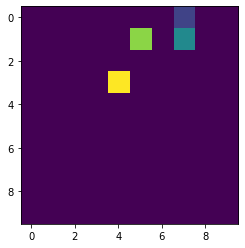

Step 12


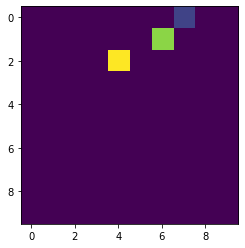

Step 13


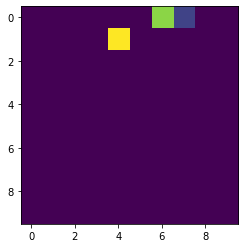

Step 14


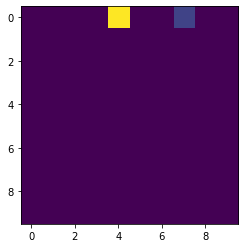

Step 15


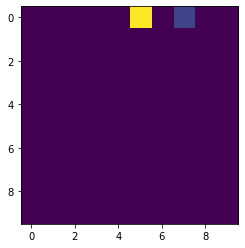

Step 16


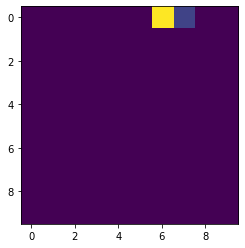

Step 17


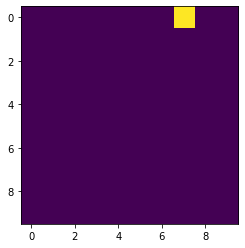

In [26]:
# Only carry out the optimal policy trained via Q-learning.
count = 0
ended = [0] * config['NUM_AGENTS']
rewards_greedy_2 = []
states_temp = env_2.reset()
for i in range(config['NUM_AGENTS']):
    rewards_greedy_2.append([])
    states.append(states_temp[i][0] * config['GRID_SIZE'] +\
                  states_temp[i][1])
    
while True:
    actions = []
    for i in range(config['NUM_AGENTS']):
        actions.append(agents_2[i].get_action(states[i], training = False))
    for i in range(config['NUM_AGENTS']):
        if ended[i] > 0:
            actions[i] = 4
    next_states_temp, rewards, dones, _ = env_2.step(actions)
    next_states = []
    for i in range(config['NUM_AGENTS']):
        next_states.append(next_states_temp[i][0] * config['GRID_SIZE'] +\
                           next_states_temp[i][1])
        rewards_greedy_2[i].append(rewards[i])
        if ended[i] == 0 and dones[i] > 0:
            ended[i] = dones[i]
        elif ended[i] == 1:
            rewards[i] = 0
        else:
            pass
    states = next_states
    count += 1

    print(f"Step {count}")
    env_2.render()
    plt.show()
    time.sleep(1)
    
    if sum(dones) == config['NUM_AGENTS']:
        break

`Discussion on the result`<br>
All agents takes one more step than the optimal number of steps to reach the goal. The results are more or less showing decent performance. However, it needs to be examined if all agents can arrive at their own goals in the optimal number of steps via hyperparameter tuning.

Total Rewards per episode (evaluation results)

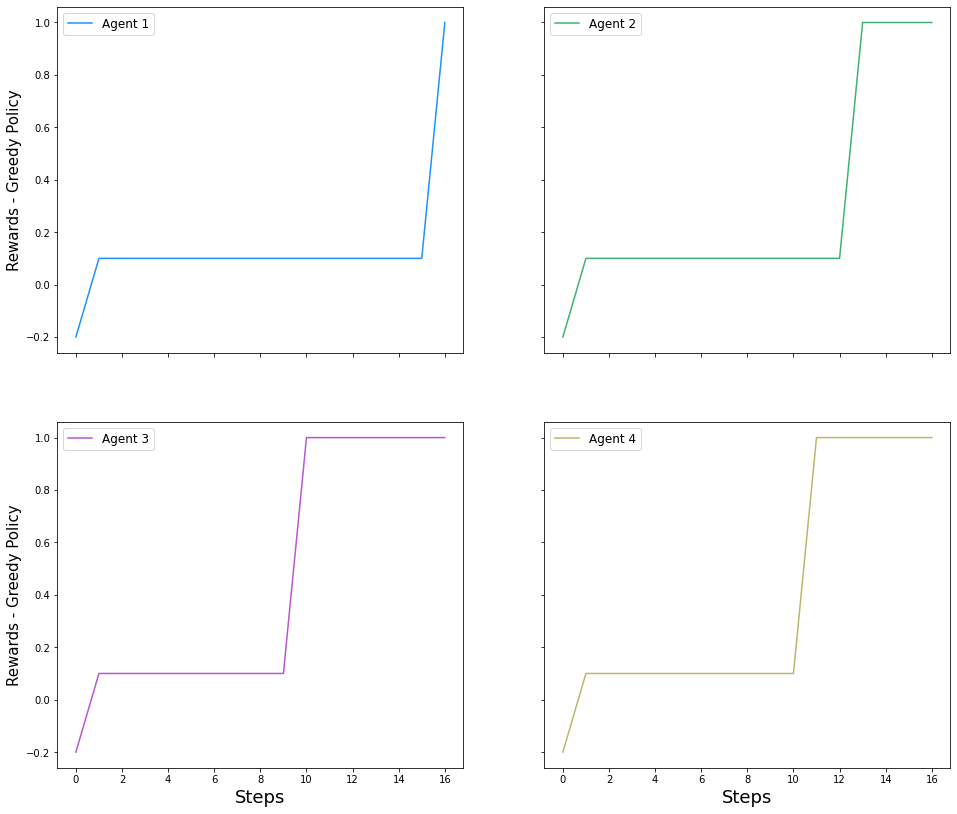

In [27]:
colors = ["dodgerblue", "mediumseagreen", "mediumorchid", "darkkhaki"]

fig, axes = plt.subplots(2, 2, sharex = True, sharey = True,
                         figsize = (16, 14))
for i in range(config['NUM_AGENTS']):
    j = i // 2
    k = i % 2
    axes[j][k].plot(rewards_greedy_2[i], color = colors[i])
    if k == 0:
        axes[j][k].set_ylabel("Rewards - Greedy Policy", color = "black",
                              fontsize = 15)
    if j == 1:
        axes[j][k].set_xlabel("Steps", fontsize = 18)
    axes[j][k].legend(['Agent ' + str(i + 1)], fontsize = 12)
plt.show()

## 3. Apply Q-learning algorithm to solve the environment that you choose in Part 1.3. We understand, that sometimes the environment that you choose before might be hard to solve using Q-learning. You are welcome to either solve the most simple multi-agent setup of that env, e.g. with 2-agents or update your chosen environment.

In [28]:
class TDAgentLBF:
    def __init__(self,
                 gamma: float,
                 num_states: int,
                 num_actions: int,
                 eps: float, # the parameter for epsilon-greedy policy
                 lr: float, # learning rate
                 num_steps: int):
        self.gamma = gamma
        self.num_states = num_states
        self.num_actions = num_actions
        self.lr = lr
        self.eps = eps
        self.num_steps = num_steps

        # Initialize state value function, 'V', and
        # action value function, 'Q'.
        self.v = None
        self.q = None
        self.reset_values()
        
        # Initialize "policy Q".
        # "policy Q" is the one used for policy generation.
        self._policy_q = None
        self.reset_policy()

    def reset_values(self):
        self.v = np.zeros(shape = self.num_states)
        self.q = np.zeros(shape = (self.num_states +(self.num_actions,)))

    def reset_policy(self):
        self._policy_q = np.zeros(shape = (
            self.num_states + (self.num_actions,)))

    def get_action(self, state, training = True):
        prob = np.random.uniform(0.0, 1.0, 1)
        # epsilon-greedy policy over Q
        if prob <= self.eps and training == True: # random policy with epsilon probability
            action = np.random.choice(range(self.num_actions))
        # greedy policy
        else:
            state = state.astype(int)
            action = self._policy_q[state[0], state[1], state[2],
                                    state[3], state[4], state[5],
                                    state[6], state[7], state[8], :].argmax()
        return action

In [29]:
class QLearnerLBF(TDAgentLBF):
    # All arguments except for the number of steps in TDAgent exist here.
    def __init__(self,
                 gamma: float,
                 num_states: int,
                 num_actions: int,
                 eps: float,
                 lr: float):
        # Inherit TDAgent.
        super(QLearnerLBF, self).__init__(gamma = gamma,
                                       num_states = num_states,
                                       num_actions = num_actions,
                                       eps = eps,
                                       lr = lr,
                                       # Set this consistent with TD(n).
                                       # In this case, TD(0).
                                       num_steps = 1)

    def get_action(self, state, training = True):
        prob = np.random.uniform(0.0, 1.0, 1)
        # e-greedy policy over Q
        if prob <= self.eps and training == True: # random policy with epsilon probability
            action = np.random.choice(range(self.num_actions))
        # greedy policy
        else:
            state = state.astype(int)
            action = self.q[state[0], state[1], state[2],
                            state[3], state[4], state[5],
                            state[6], state[7], state[8], :].argmax()
        return action

    def update_sample(self, state, action, reward, next_state, done):
        s, a, r, ns = state.astype(int), action.astype(int), reward, next_state.astype(int)
        # Q-Learning target
        td_target = r + self.gamma * self.q[ns[0], ns[1], ns[2],
                                            ns[3], ns[4], ns[5],
                                            ns[6], ns[7], ns[8], :].max() * (1 - done)
        self.q[
            s[0], s[1], s[2],
            s[3], s[4], s[5],
            s[6], s[7], s[8], a] += self.lr *\
        (td_target - self.q[s[0], s[1], s[2],
                            s[3], s[4], s[5],
                            s[6], s[7], s[8], a])

hyperparameters

In [30]:
env_3 = gym.make("Foraging-5x5-2p-1f-v2")
num_agents_3 = 2

num_episodes = 5000
gamma = 0.99 # discount rate
lr = 0.01
eps = 1.0 # the maximum eps: 1.0
factor = (1e-2)**(1 / num_episodes) # the minimum eps: 0.01
grid_size_3 = int(env_3.observation_space[0].high[0]) + 1
num_states_3 = ((int(env_3.observation_space[0].high[0]) + 1),
                (int(env_3.observation_space[0].high[1]) + 1),
                (int(env_3.observation_space[0].high[2]) + 1),
                (int(env_3.observation_space[0].high[3]) + 1),
                (int(env_3.observation_space[0].high[4]) + 1),
                (int(env_3.observation_space[0].high[5]) + 1),
                (int(env_3.observation_space[0].high[6]) + 1),
                (int(env_3.observation_space[0].high[7]) + 1),
                (int(env_3.observation_space[0].high[8]) + 1))
num_actions_3 = env_3.action_space[0].n

Instantiate agents.

In [31]:
agents_3 = []
for i in range(num_agents_3):
    agents_3.append(QLearnerLBF(gamma = gamma,
                                num_states = num_states_3,
                                num_actions = num_actions_3,
                                eps = eps,
                                lr = lr))

qlearning_rewards_3 = []

training

In [32]:
start = time.time()

eps_values_3 = []
print_every = 1000

for ep in range(num_episodes):
    states = env_3.reset()
    
    total_reward_3 = 0

    while True:
        actions = []
                
        for i in range(num_agents_3):
            # epsilon-greedy policy
            actions.append(agents_3[i].get_action(states[i]))
        
        next_states, rewards, dones, _ = env_3.step(actions)
        
        for i in range(num_agents_3):
            # Q-learning: Update Q-table using greedy policy.
            agents_3[i].update_sample(state = states[i],
                                      action = actions[i],
                                      reward = rewards[i],
                                      next_state = next_states[i],
                                      done = dones[i])
            total_reward_3 += rewards[i]
            
        states = next_states
        
        if np.all(dones) == True:
            break
            
    qlearning_rewards_3.append(total_reward_3)
    eps_values_3.append(agents_3[0].eps)
    
    for i in range(num_agents_3):
        agents_3[i].eps *= factor
    
    if ep % print_every == (print_every - 1):
        print(f"Episode: {ep + 1}\t| Epsilon: {agents_3[0].eps:.2f}")
        
end = time.time()

print(f"For {num_agents_3} agents," +
      f" the elapsed time: {round(end - start, 1)} seconds")

Episode: 1000	| Epsilon: 0.40
Episode: 2000	| Epsilon: 0.16
Episode: 3000	| Epsilon: 0.06
Episode: 4000	| Epsilon: 0.03
Episode: 5000	| Epsilon: 0.01
For 2 agents, the elapsed time: 32.7 seconds


Total Rewards per episode

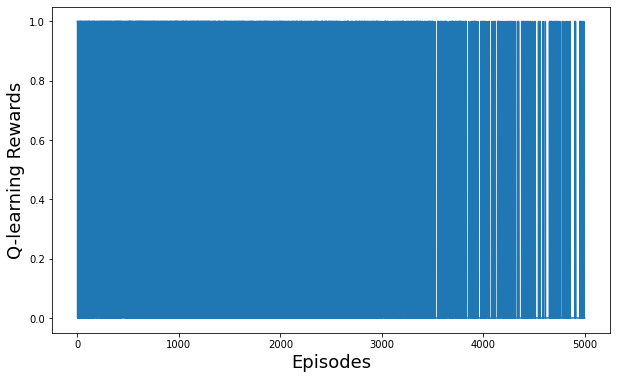

In [33]:
plt.subplots(figsize = (10, 6))
plt.plot(qlearning_rewards_3)
plt.xlabel("Episodes", fontsize = 18)
plt.ylabel("Q-learning Rewards", color = "black", fontsize = 18)
plt.show()

`Discussion on the result`<br>
The Qlearning agents fail to be trained. The reason seems to be the fact that there are too many dimensions to solve the problem using a qlearning algorithm.

Epsilon Decay Visualization

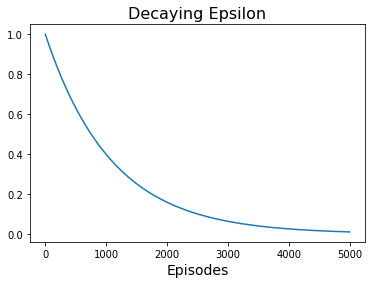

In [34]:
plt.plot(eps_values_3)
plt.xlabel("Episodes", fontsize = 14)
plt.title("Decaying Epsilon", fontsize = 16);

Evaluation Results

In [35]:
# Only carry out the optimal policy trained via Q-learning.
count = 0
rewards_greedy_3 = 0
states = env_3.reset()
    
while True:
    actions = []
    for i in range(num_agents_3):
        actions.append(agents_3[i].get_action(states[i], training = False))
    next_states, rewards, dones, _ = env_3.step(actions)
    for i in range(num_agents_3):
        rewards_greedy_3 += rewards[i]
    states = next_states
    count += 1

    env_3.render()
    plt.show()
    time.sleep(1)
    
    if np.all(dones) == True:
        break

`Discussion on the result`<br>
Agents do not move due to failure in training.

Total Rewards per episode (evaluation results)

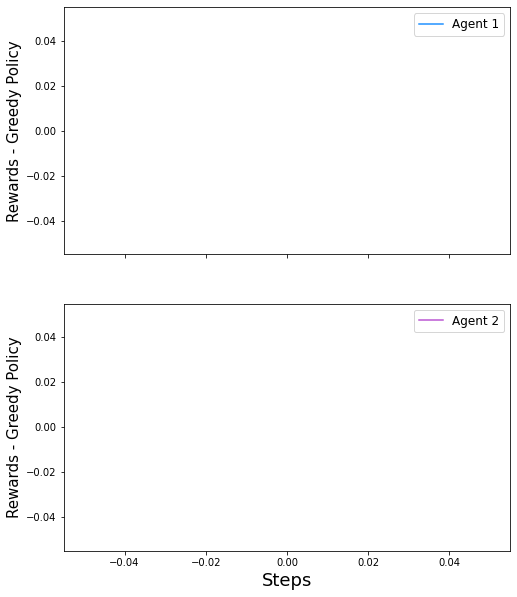

In [36]:
colors = ["dodgerblue", "mediumorchid"]

fig, axes = plt.subplots(2, 1, sharex = True, sharey = True,
                         figsize = (8, 10))
for i in range(num_agents_3):
    axes[i].plot(rewards_greedy_3, color = colors[i])
    axes[i].set_ylabel("Rewards - Greedy Policy", color = "black",
                       fontsize = 15)
    if i == 1:
        axes[i].set_xlabel("Steps", fontsize = 18)
    axes[i].legend(['Agent ' + str(i + 1)], fontsize = 12)
plt.show()

## 4. Use hyperparameter tuning on at least two parameters to get better results. Parameters to tune:
- Discount factor ($\gamma$)
- Epsilon decay rate
- Epsilon min/max values
- Number of episodes
- Max timesteps

MAGridWorld: learning rate (0.01 $\rightarrow$ 0.05)

In [37]:
num_episodes = 5000
gamma = 0.99 # discount rate
lr = 0.05
goal_pos = np.random.choice(config['GRID_SIZE'])
env_4 = MAGridWorld2(size = size, num_agents = num_agents,
                     goal_pos = goal_pos)
eps = 1.0 # the maximum eps: 1.0
factor = (1e-2)**(1 / num_episodes) # the minimum eps: 0.01
num_states = env_4.observation_space.shape[0] * env_4.observation_space.shape[1]
num_actions = env_4.action_space.n

In [38]:
agents_4 = []
for i in range(config['NUM_AGENTS']):
    agents_4.append(QLearner(gamma = gamma,
                             num_states = num_states,
                             num_actions = num_actions,
                             eps = eps,
                             lr = lr))

qlearning_rewards_4 = []
for _ in range(config['NUM_AGENTS']):
    qlearning_rewards_4.append([])

In [39]:
start = time.time()

eps_values_4 = []
print_every = 1000

for ep in range(num_episodes):
    states_temp = env_4.reset()
    states = []
    for i in range(config['NUM_AGENTS']):
        states.append(states_temp[i][0] * config['GRID_SIZE'] +\
                      states_temp[i][1])
    total_rewards = [0] * config['NUM_AGENTS']

    while True:
        actions = []
                
        for i in range(config['NUM_AGENTS']):
            # epsilon-greedy policy
            actions.append(agents_4[i].get_action(states[i]))
        next_states_temp, rewards, dones, _ = env_4.step(actions)
        next_states = []
        for i in range(config['NUM_AGENTS']):
            next_states.append(next_states_temp[i][0] * config['GRID_SIZE'] +\
                               next_states_temp[i][1])
                            
        for i in range(config['NUM_AGENTS']):
            # Q-learning: Update Q-table using greedy policy.
            agents_4[i].update_sample(state = states[i],
                                      action = actions[i],
                                      reward = rewards[i],
                                      next_state = next_states[i],
                                      done = dones[i])
            total_rewards[i] += rewards[i]
        
        states = next_states
        
        if sum(dones) == config['NUM_AGENTS']:
            break

    for i in range(config['NUM_AGENTS']):
        qlearning_rewards_4[i].append(total_rewards[i])            
            
    eps_values_4.append(agents_4[0].eps)
    
    for i in range(config['NUM_AGENTS']):
        agents_4[i].eps *= factor
    
    if ep % print_every == (print_every - 1):
        print(f"Episode: {ep + 1}\t| Epsilon: {agents_4[0].eps:.2f}")
        
end = time.time()

print(f"For {config['NUM_AGENTS']} agents," +
      f" the elapsed time: {round(end - start, 1)} seconds")

Episode: 1000	| Epsilon: 0.40
Episode: 2000	| Epsilon: 0.16
Episode: 3000	| Epsilon: 0.06
Episode: 4000	| Epsilon: 0.03
Episode: 5000	| Epsilon: 0.01
For 4 agents, the elapsed time: 10.2 seconds


MAGridWorld: Max timesteps (default $\rightarrow$ 20)

In [40]:
num_episodes = 5000
gamma = 0.99 # discount rate
lr = 0.01
goal_pos = np.random.choice(config['GRID_SIZE'])
max_timestep = 20
env_5 = MAGridWorld2(size = size, num_agents = num_agents,
                     goal_pos = goal_pos, max_timestep = max_timestep)
eps = 1.0 # the maximum eps: 1.0
factor = (1e-2)**(1 / num_episodes) # the minimum eps: 0.01
num_states = env_5.observation_space.shape[0] * env_5.observation_space.shape[1]
num_actions = env_5.action_space.n

In [41]:
agents_5 = []
for i in range(config['NUM_AGENTS']):
    agents_5.append(QLearner(gamma = gamma,
                             num_states = num_states,
                             num_actions = num_actions,
                             eps = eps,
                             lr = lr))

qlearning_rewards_5 = []
for _ in range(config['NUM_AGENTS']):
    qlearning_rewards_5.append([])

In [42]:
start = time.time()

eps_values_5 = []
print_every = 1000

for ep in range(num_episodes):
    states_temp = env_5.reset()
    states = []
    for i in range(config['NUM_AGENTS']):
        states.append(states_temp[i][0] * config['GRID_SIZE'] +\
                      states_temp[i][1])
    total_rewards = [0] * config['NUM_AGENTS']

    while True:
        actions = []
                
        for i in range(config['NUM_AGENTS']):
            # epsilon-greedy policy
            actions.append(agents_5[i].get_action(states[i]))
        next_states_temp, rewards, dones, _ = env_5.step(actions)
        next_states = []
        for i in range(config['NUM_AGENTS']):
            next_states.append(next_states_temp[i][0] * config['GRID_SIZE'] +\
                               next_states_temp[i][1])
                            
        for i in range(config['NUM_AGENTS']):
            # Q-learning: Update Q-table using greedy policy.
            agents_5[i].update_sample(state = states[i],
                                      action = actions[i],
                                      reward = rewards[i],
                                      next_state = next_states[i],
                                      done = dones[i])
            total_rewards[i] += rewards[i]
        
        states = next_states
        
        if sum(dones) == config['NUM_AGENTS']:
            break

    for i in range(config['NUM_AGENTS']):
        qlearning_rewards_5[i].append(total_rewards[i])            
            
    eps_values_5.append(agents_5[0].eps)
    
    for i in range(config['NUM_AGENTS']):
        agents_5[i].eps *= factor
    
    if ep % print_every == (print_every - 1):
        print(f"Episode: {ep + 1}\t| Epsilon: {agents_5[0].eps:.2f}")
        
end = time.time()

print(f"For {config['NUM_AGENTS']} agents," +
      f" the elapsed time: {round(end - start, 1)} seconds")

Episode: 1000	| Epsilon: 0.40
Episode: 2000	| Epsilon: 0.16
Episode: 3000	| Epsilon: 0.06
Episode: 4000	| Epsilon: 0.03
Episode: 5000	| Epsilon: 0.01
For 4 agents, the elapsed time: 7.2 seconds


MAGridWorld2: learning rate (0.01 $\rightarrow$ 0.05)

In [43]:
num_episodes = 5000
gamma = 0.99 # discount rate
lr = 0.05
goal_pos = np.random.choice(config['GRID_SIZE'])
env_6 = MAGridWorld2(size = size, num_agents = num_agents,
                     goal_pos = goal_pos)
eps = 1.0 # the maximum eps: 1.0
factor = (1e-2)**(1 / num_episodes) # the minimum eps: 0.01
num_states = env_6.observation_space.shape[0] * env_6.observation_space.shape[1]
num_actions = env_6.action_space.n

In [44]:
agents_6 = []
for i in range(config['NUM_AGENTS']):
    agents_6.append(QLearner(gamma = gamma,
                             num_states = num_states,
                             num_actions = num_actions,
                             eps = eps,
                             lr = lr))

qlearning_rewards_6 = []
for _ in range(config['NUM_AGENTS']):
    qlearning_rewards_6.append([])

In [45]:
start = time.time()
eps_values_6 = []
print_every = 1000

for ep in range(num_episodes):
    states_temp = env_6.reset()
    states = []
    ended = [0] * config['NUM_AGENTS']
    for i in range(config['NUM_AGENTS']):
        states.append(states_temp[i][0] * config['GRID_SIZE'] +\
                      states_temp[i][1])
    total_rewards = [0] * config['NUM_AGENTS']

    while True:
        actions = []
                
        for i in range(config['NUM_AGENTS']):
            # epsilon-greedy policy
            actions.append(agents_6[i].get_action(states[i]))
        for i in range(config['NUM_AGENTS']):
            if ended[i] > 0: # If the agent has already arrived at the goal..
                actions[i] = 4
        next_states_temp, rewards, dones, _ = env_6.step(actions)
        next_states = []
        for i in range(config['NUM_AGENTS']):
            next_states.append(next_states_temp[i][0] * config['GRID_SIZE'] +\
                               next_states_temp[i][1])
            if ended[i] > 0:
                rewards[i] = 0
                dones[i] = 1
                            
        for i in range(config['NUM_AGENTS']):
            # Q-learning: Update Q-table using greedy policy.
            agents_6[i].update_sample(state = states[i],
                                      action = actions[i],
                                      reward = rewards[i],
                                      next_state = next_states[i],
                                      done = dones[i])
            total_rewards[i] += rewards[i]
            if dones[i] > 0:
                ended[i] = dones[i]
        
        states = next_states
        
        if sum(dones) == config['NUM_AGENTS']:
            break

    for i in range(config['NUM_AGENTS']):
        qlearning_rewards_6[i].append(total_rewards[i])            
            
    eps_values_6.append(agents_6[0].eps)
    
    for i in range(config['NUM_AGENTS']):
        agents_6[i].eps *= factor
    
    if ep % print_every == (print_every - 1):
        print(f"Episode: {ep + 1}\t| Epsilon: {agents_6[0].eps:.2f}")
        
end = time.time()

print(f"For {config['NUM_AGENTS']} agents," +
      f" the elapsed time: {round(end - start, 1)} seconds")

Episode: 1000	| Epsilon: 0.40
Episode: 2000	| Epsilon: 0.16
Episode: 3000	| Epsilon: 0.06
Episode: 4000	| Epsilon: 0.03
Episode: 5000	| Epsilon: 0.01
For 4 agents, the elapsed time: 10.7 seconds


MAGridWorld2: Max timesteps (default $\rightarrow$ 20)

In [46]:
num_episodes = 5000
gamma = 0.99 # discount rate
lr = 0.01
max_timestep = 20
env_7 = MAGridWorld2(size = size, num_agents = num_agents,
                     goal_pos = goal_pos, max_timestep = max_timestep)
eps = 1.0 # the maximum eps: 1.0
factor = (1e-2)**(1 / num_episodes) # the minimum eps: 0.01
num_states = env_7.observation_space.shape[0] * env_7.observation_space.shape[1]
num_actions = env_7.action_space.n

In [47]:
agents_7 = []
for i in range(config['NUM_AGENTS']):
    agents_7.append(QLearner(gamma = gamma,
                             num_states = num_states,
                             num_actions = num_actions,
                             eps = eps,
                             lr = lr))

qlearning_rewards_7 = []
for _ in range(config['NUM_AGENTS']):
    qlearning_rewards_7.append([])

In [48]:
start = time.time()
eps_values_7 = []
print_every = 1000

for ep in range(num_episodes):
    states_temp = env_7.reset()
    states = []
    ended = [0] * config['NUM_AGENTS']
    for i in range(config['NUM_AGENTS']):
        states.append(states_temp[i][0] * config['GRID_SIZE'] +\
                      states_temp[i][1])
    total_rewards = [0] * config['NUM_AGENTS']

    while True:
        actions = []
                
        for i in range(config['NUM_AGENTS']):
            # epsilon-greedy policy
            actions.append(agents_7[i].get_action(states[i]))
        for i in range(config['NUM_AGENTS']):
            if ended[i] > 0: # If the agent has already arrived at the goal..
                actions[i] = 4
        next_states_temp, rewards, dones, _ = env_7.step(actions)
        next_states = []
        for i in range(config['NUM_AGENTS']):
            next_states.append(next_states_temp[i][0] * config['GRID_SIZE'] +\
                               next_states_temp[i][1])
            if ended[i] > 0:
                rewards[i] = 0
                dones[i] = 1
                            
        for i in range(config['NUM_AGENTS']):
            # Q-learning: Update Q-table using greedy policy.
            agents_7[i].update_sample(state = states[i],
                                      action = actions[i],
                                      reward = rewards[i],
                                      next_state = next_states[i],
                                      done = dones[i])
            total_rewards[i] += rewards[i]
            if dones[i] > 0:
                ended[i] = dones[i]
        
        states = next_states
        
        if sum(dones) == config['NUM_AGENTS']:
            break

    for i in range(config['NUM_AGENTS']):
        qlearning_rewards_7[i].append(total_rewards[i])            
            
    eps_values_7.append(agents_7[0].eps)
    
    for i in range(config['NUM_AGENTS']):
        agents_7[i].eps *= factor
    
    if ep % print_every == (print_every - 1):
        print(f"Episode: {ep + 1}\t| Epsilon: {agents_7[0].eps:.2f}")
        
end = time.time()

print(f"For {config['NUM_AGENTS']} agents," +
      f" the elapsed time: {round(end - start, 1)} seconds")

Episode: 1000	| Epsilon: 0.40
Episode: 2000	| Epsilon: 0.16
Episode: 3000	| Epsilon: 0.06
Episode: 4000	| Epsilon: 0.03
Episode: 5000	| Epsilon: 0.01
For 4 agents, the elapsed time: 8.2 seconds


LB Foraging: learning rate (0.01 $\rightarrow$ 0.05)

In [49]:
env_8 = gym.make("Foraging-5x5-2p-1f-v2")

num_episodes = 5000
gamma = 0.99 # discount rate
lr = 0.05
eps = 1.0 # the maximum eps: 1.0
factor = (1e-2)**(1 / num_episodes) # the minimum eps: 0.01

In [50]:
agents_8 = []
for i in range(num_agents_3):
    agents_8.append(QLearnerLBF(gamma = gamma,
                                num_states = num_states_3,
                                num_actions = num_actions_3,
                                eps = eps,
                                lr = lr))

qlearning_rewards_8 = []

In [51]:
start = time.time()

eps_values_8 = []
print_every = 1000

for ep in range(num_episodes):
    states = env_8.reset()
    
    total_reward_8 = 0

    while True:
        actions = []
                
        for i in range(num_agents_3):
            # epsilon-greedy policy
            actions.append(agents_8[i].get_action(states[i]))
        
        next_states, rewards, dones, _ = env_8.step(actions)
        
        for i in range(num_agents_3):
            # Q-learning: Update Q-table using greedy policy.
            agents_8[i].update_sample(state = states[i],
                                      action = actions[i],
                                      reward = rewards[i],
                                      next_state = next_states[i],
                                      done = dones[i])
            total_reward_8 += rewards[i]
                
        states = next_states
        
        if np.all(dones) == True:
            break
            
    qlearning_rewards_8.append(total_reward_8)
    eps_values_8.append(agents_8[0].eps)
    
    for i in range(num_agents_3):
        agents_8[i].eps *= factor
    
    if ep % print_every == (print_every - 1):
        print(f"Episode: {ep + 1}\t| Epsilon: {agents_8[0].eps:.2f}")
        
end = time.time()

print(f"For {num_agents_3} agents," +
      f" the elapsed time: {round(end - start, 1)} seconds")

Episode: 1000	| Epsilon: 0.40
Episode: 2000	| Epsilon: 0.16
Episode: 3000	| Epsilon: 0.06
Episode: 4000	| Epsilon: 0.03
Episode: 5000	| Epsilon: 0.01
For 2 agents, the elapsed time: 32.6 seconds


LB Foraging: $\gamma$ (0.99 $\rightarrow$ 0.95)

In [52]:
env_9 = gym.make("Foraging-5x5-2p-1f-v2")

num_episodes = 5000
gamma = 0.95 # discount rate
lr = 0.01
eps = 1.0 # the maximum eps: 1.0
factor = (1e-2)**(1 / num_episodes) # the minimum eps: 0.01

In [53]:
agents_9 = []
for i in range(num_agents_3):
    agents_9.append(QLearnerLBF(gamma = gamma,
                                num_states = num_states_3,
                                num_actions = num_actions_3,
                                eps = eps,
                                lr = lr))

qlearning_rewards_9 = []

In [54]:
start = time.time()

eps_values_9 = []
print_every = 1000

for ep in range(num_episodes):
    states = env_9.reset()
    
    total_reward_9 = 0

    while True:
        actions = []
                
        for i in range(num_agents_3):
            # epsilon-greedy policy
            actions.append(agents_9[i].get_action(states[i]))
        
        next_states, rewards, dones, _ = env_9.step(actions)
        
        for i in range(num_agents_3):
            # Q-learning: Update Q-table using greedy policy.
            agents_9[i].update_sample(state = states[i],
                                      action = actions[i],
                                      reward = rewards[i],
                                      next_state = next_states[i],
                                      done = dones[i])
            total_reward_9 += rewards[i]
                
        states = next_states
        
        if np.all(dones) == True:
            break
            
    qlearning_rewards_9.append(total_reward_9)
    eps_values_9.append(agents_9[0].eps)
    
    for i in range(num_agents_3):
        agents_9[i].eps *= factor
    
    if ep % print_every == (print_every - 1):
        print(f"Episode: {ep + 1}\t| Epsilon: {agents_9[0].eps:.2f}")
        
end = time.time()

print(f"For {num_agents_3} agents," +
      f" the elapsed time: {round(end - start, 1)} seconds")

Episode: 1000	| Epsilon: 0.40
Episode: 2000	| Epsilon: 0.16
Episode: 3000	| Epsilon: 0.06
Episode: 4000	| Epsilon: 0.03
Episode: 5000	| Epsilon: 0.01
For 2 agents, the elapsed time: 33.0 seconds


## 5. Compare the results for all the environments.

Comparing Multi-Agent GridWorld Environments


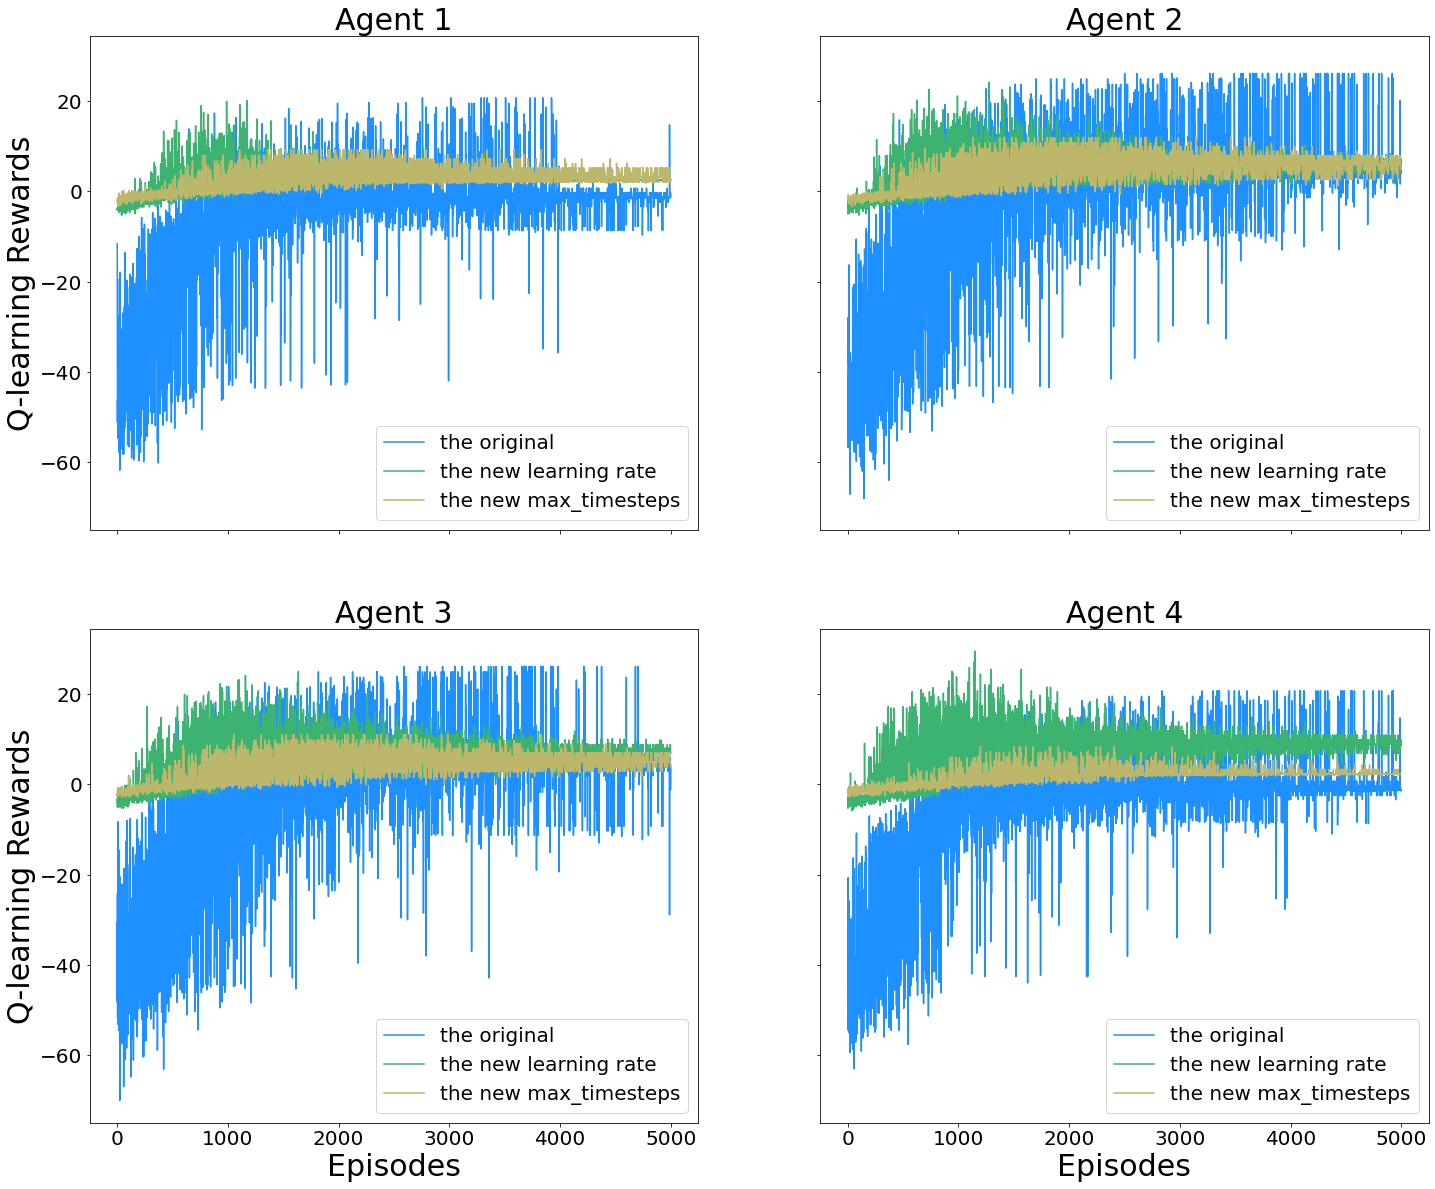

In [55]:
colors = ["dodgerblue", "mediumseagreen", "darkkhaki"]

print("Comparing Multi-Agent GridWorld Environments")

fig, axes = plt.subplots(2, 2, sharex = True, sharey = True,
                         figsize = (24, 20))
axes[0][0].plot(qlearning_rewards[0], color = colors[0])
axes[0][0].plot(qlearning_rewards_4[0], color = colors[1])
axes[0][0].plot(qlearning_rewards_5[0], color = colors[2])
axes[0][0].set_title('Agent 1', fontsize = 30)

axes[0][1].plot(qlearning_rewards[1], color = colors[0])
axes[0][1].plot(qlearning_rewards_4[1], color = colors[1])
axes[0][1].plot(qlearning_rewards_5[1], color = colors[2])
axes[0][1].set_title('Agent 2', fontsize = 30)

axes[1][0].plot(qlearning_rewards[2], color = colors[0])
axes[1][0].plot(qlearning_rewards_4[2], color = colors[1])
axes[1][0].plot(qlearning_rewards_5[2], color = colors[2])
axes[1][0].set_title('Agent 3', fontsize = 30)

axes[1][1].plot(qlearning_rewards[3], color = colors[0])
axes[1][1].plot(qlearning_rewards_4[3], color = colors[1])
axes[1][1].plot(qlearning_rewards_5[3], color = colors[2])
axes[1][1].set_title('Agent 4', fontsize = 30)

axes[0][0].set_ylabel("Q-learning Rewards", color = "black",
                      fontsize = 30)
axes[1][0].set_ylabel("Q-learning Rewards", color = "black",
                      fontsize = 30)
axes[0][0].tick_params(axis = 'y', which = 'major', labelsize = 20)
axes[1][0].tick_params(axis = 'both', which = 'major', labelsize = 20)
axes[1][0].set_xlabel("Episodes", fontsize = 30)
axes[1][1].set_xlabel("Episodes", fontsize = 30)
axes[1][1].tick_params(axis = 'x', which = 'major', labelsize = 20)

for i in range(2):
    for j in range(2):
        axes[i][j].legend(
            ['the original', 'the new learning rate', 'the new max_timesteps'],
            fontsize = 20, loc = 'lower right')

plt.show()

`Discussion on hyperparameter tuning`<br>
After changing the learning rate or the max_timesteps, the rewards seem to increase on average for all agents. In addition, the agents are showing less volatile performance in the new settings than the original hyperparameter settings.

Comparing Multi-Agent GridWorld2 Environments


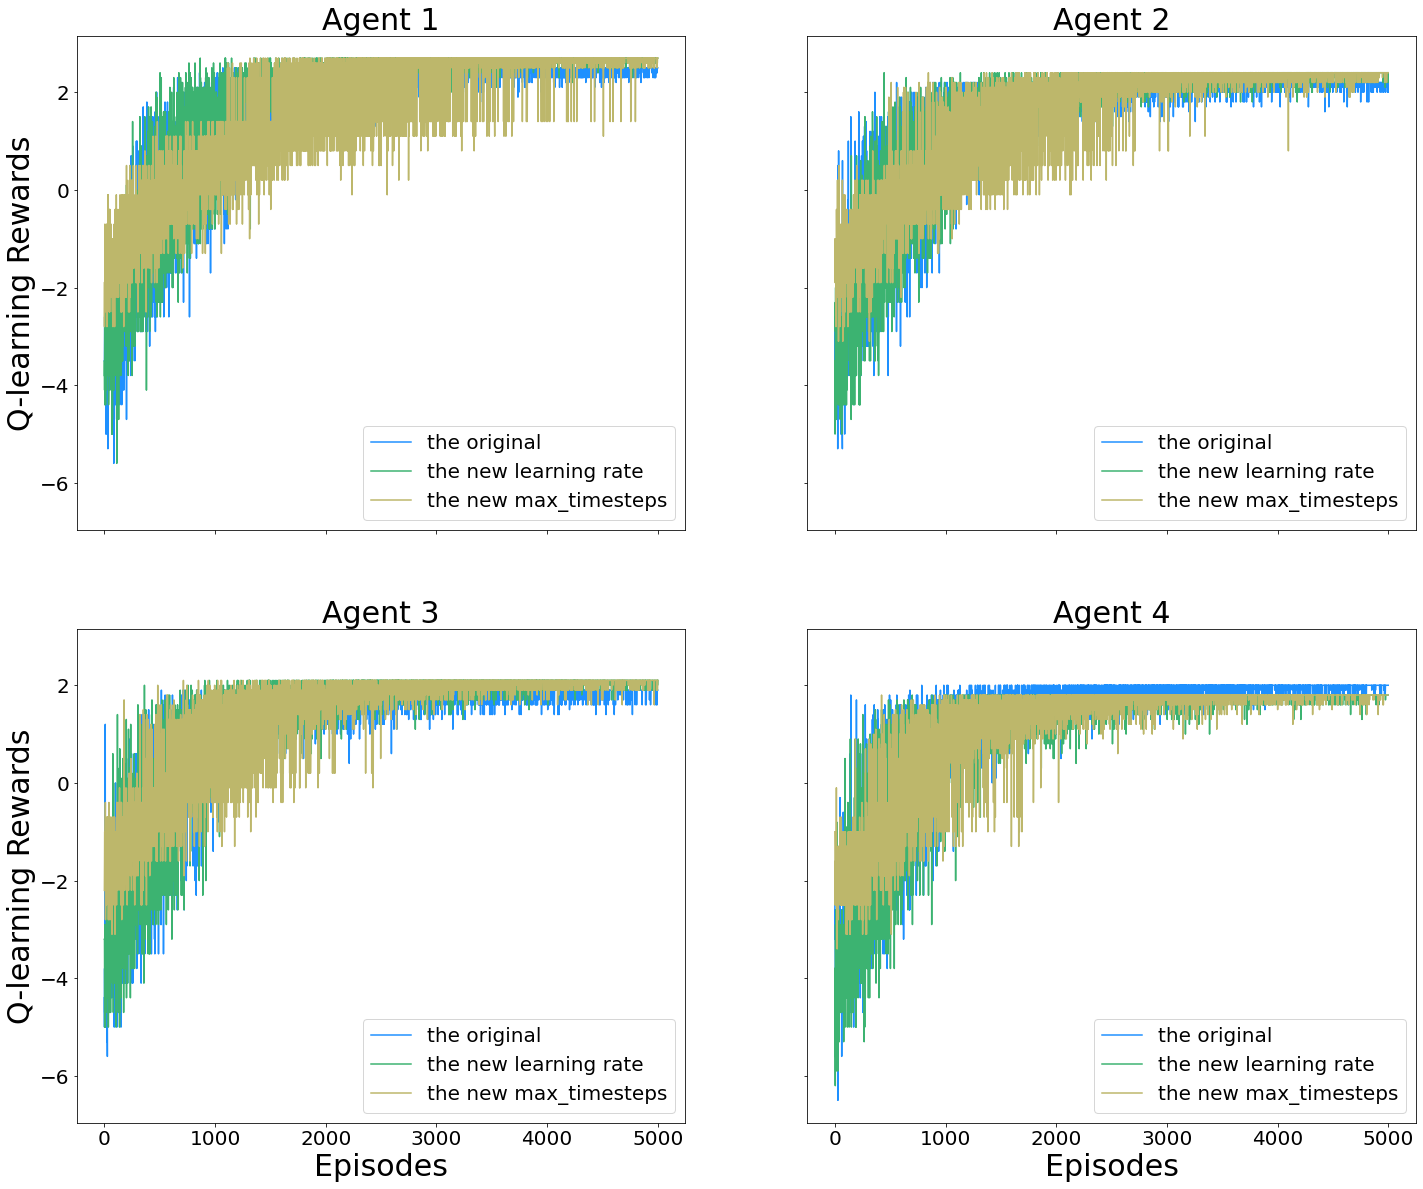

In [56]:
print("Comparing Multi-Agent GridWorld2 Environments")

fig, axes = plt.subplots(2, 2, sharex = True, sharey = True,
                         figsize = (24, 20))
axes[0][0].plot(qlearning_rewards_2[0], color = colors[0])
axes[0][0].plot(qlearning_rewards_6[0], color = colors[1])
axes[0][0].plot(qlearning_rewards_7[0], color = colors[2])
axes[0][0].set_title('Agent 1', fontsize = 30)

axes[0][1].plot(qlearning_rewards_2[1], color = colors[0])
axes[0][1].plot(qlearning_rewards_6[1], color = colors[1])
axes[0][1].plot(qlearning_rewards_7[1], color = colors[2])
axes[0][1].set_title('Agent 2', fontsize = 30)

axes[1][0].plot(qlearning_rewards_2[2], color = colors[0])
axes[1][0].plot(qlearning_rewards_6[2], color = colors[1])
axes[1][0].plot(qlearning_rewards_7[2], color = colors[2])
axes[1][0].set_title('Agent 3', fontsize = 30)

axes[1][1].plot(qlearning_rewards_2[3], color = colors[0])
axes[1][1].plot(qlearning_rewards_6[3], color = colors[1])
axes[1][1].plot(qlearning_rewards_7[3], color = colors[2])
axes[1][1].set_title('Agent 4', fontsize = 30)

axes[0][0].set_ylabel("Q-learning Rewards", color = "black",
                      fontsize = 30)
axes[1][0].set_ylabel("Q-learning Rewards", color = "black",
                      fontsize = 30)
axes[0][0].tick_params(axis = 'y', which = 'major', labelsize = 20)
axes[1][0].tick_params(axis = 'both', which = 'major', labelsize = 20)
axes[1][0].set_xlabel("Episodes", fontsize = 30)
axes[1][1].set_xlabel("Episodes", fontsize = 30)
axes[1][1].tick_params(axis = 'x', which = 'major', labelsize = 20)

for i in range(2):
    for j in range(2):
        axes[i][j].legend(
            ['the original', 'the new learning rate', 'the new max_timesteps'],
            fontsize = 20, loc = 'lower right')

plt.show()

`Discussion on hyperparameter tuning`<br>
Three settings are showing almost the same performance. However, as the number of max_timesteps decreases, the volitility of rewards is reduced, which is natural.

Comparing LB Foraging Environments


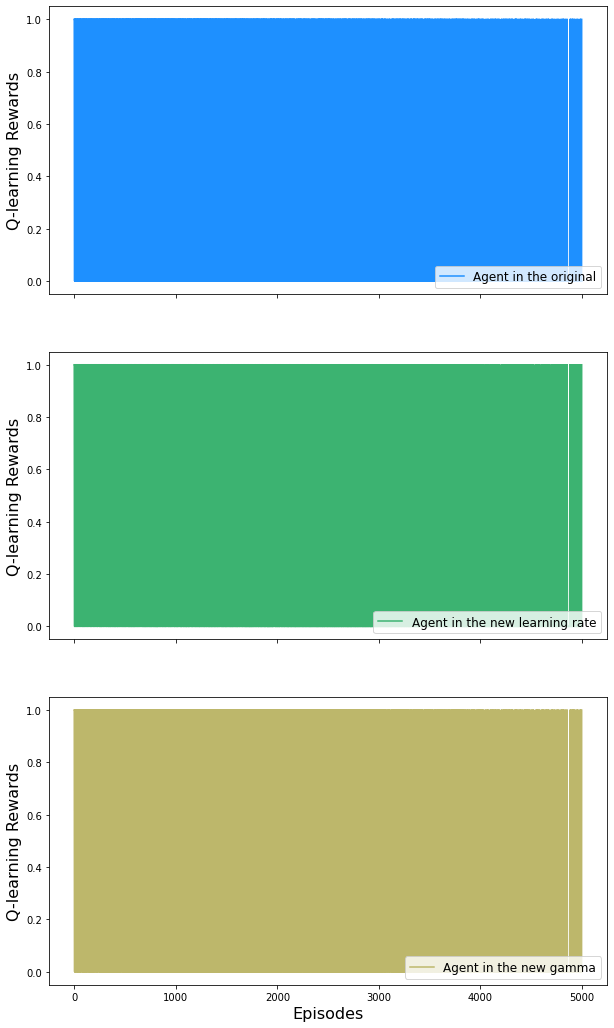

In [57]:
categories = ['the original', 'the new learning rate', 'the new gamma']

print("Comparing LB Foraging Environments")

fig, axes = plt.subplots(3, 1, sharex = True, sharey = True,
                         figsize = (10, 18))
for i in range(3):
    axes[i].plot(qlearning_rewards_3, color = colors[i])
    axes[i].plot(qlearning_rewards_8, color = colors[i])
    axes[i].plot(qlearning_rewards_9, color = colors[i])
    axes[i].set_ylabel("Q-learning Rewards", color = "black",
                              fontsize = 16)
    if i == 2:
        axes[i].set_xlabel("Episodes", fontsize = 16)
    axes[i].legend(['Agent in ' + str(categories[i])], fontsize = 12, loc = 'lower right')
plt.show()

`Discussion on hyperparameter tuning`<br>
Hyperparameter tunings in the above trials do not work. To improve performance, it seems that I need to apply other algorithms such as deep reinforcement learning algorithms instead.